# Домашнє завдання №8: Причинно-наслідковий аналіз у продуктовій аналітиці

## Дослідження впливу персоналізованих рекомендацій на утримання користувачів

**Студент:** Фефелов Ілля  
**Дисципліна:** Продуктова аналітика та Прикладна статистика  
**Дата:** 7 листопада 2025

---

## Мета роботи

Оцінити вплив нової функції персоналізованих рекомендацій на утримання користувачів мобільного застосунку для вивчення мов, використовуючи методи причинно-наслідкового аналізу:

1. **Кореляційний аналіз** — визначення асоціації між використанням функції та утриманням
2. **Randomized Controlled Trial (RCT)** — порівняння тестової та контрольної груп
3. **Propensity Score Matching (PSM)** — контроль за змішувачами (confounders) для оцінки причинного ефекту

---

## Опис експерименту

- **Тестова група (Test):** Користувачі, які отримали нову функцію персоналізованих рекомендацій
- **Контрольна група (Control):** Користувачі без нової функції
- **Результати (outcomes):**
  - `Retention_7d`: Повернення через 7 днів після реєстрації (0/1)
  - `Retention_30d`: Повернення через 30 днів після реєстрації (0/1)
- **Коваріати (confounders):**
  - `Avg_Session_Time`: Середній час сесії користувача (хвилини)
  - `Region`: Географічний регіон (EU, US, Asia)

## Імпорт бібліотек та налаштування середовища

In [1]:
# Основні бібліотеки для роботи з даними
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Статистичні тести та моделі
from scipy.stats import ttest_ind, pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors

# Візуалізація
import matplotlib.pyplot as plt
import seaborn as sns

# Налаштування стилю графіків
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Фіксація random seed для відтворюваності
np.random.seed(42)

print("✓ Бібліотеки імпортовано успішно")

✓ Бібліотеки імпортовано успішно


## Завантаження та підготовка даних

In [2]:
# Завантаження даних
df = pd.read_csv('user_data_2000.csv')

# Перегляд структури даних
print("="*80)
print("СТРУКТУРА ДАНИХ")
print("="*80)
print(f"\nРозмір датасету: {df.shape[0]} рядків, {df.shape[1]} колонок")
print(f"\nКолонки: {list(df.columns)}")
print(f"\nТипи даних:\n{df.dtypes}")
print(f"\nПропущені значення:\n{df.isnull().sum()}")

print("\n" + "="*80)
print("ПЕРШІ 5 РЯДКІВ")
print("="*80)
print(df.head())

print("\n" + "="*80)
print("ОПИСОВА СТАТИСТИКА")
print("="*80)
print(df.describe())

# Перевірка унікальних значень категоріальних змінних
print("\n" + "="*80)
print("КАТЕГОРІАЛЬНІ ЗМІННІ")
print("="*80)
print(f"\nГрупи (Group):")
print(df['Group'].value_counts())
print(f"\nРегіони (Region):")
print(df['Region'].value_counts())

# Створення бінарного індикатора лікування (treatment)
df['Treatment'] = (df['Group'] == 'Test').astype(int)

print("\n✓ Дані завантажено та підготовлено")

СТРУКТУРА ДАНИХ

Розмір датасету: 2000 рядків, 6 колонок

Колонки: ['User_ID', 'Group', 'Retention_7d', 'Retention_30d', 'Avg_Session_Time', 'Region']

Типи даних:
User_ID              int64
Group               object
Retention_7d         int64
Retention_30d        int64
Avg_Session_Time     int64
Region              object
dtype: object

Пропущені значення:
User_ID             0
Group               0
Retention_7d        0
Retention_30d       0
Avg_Session_Time    0
Region              0
dtype: int64

ПЕРШІ 5 РЯДКІВ
   User_ID    Group  Retention_7d  Retention_30d  Avg_Session_Time Region
0      101     Test             0              1                 7     EU
1      102  Control             1              0                13     US
2      103     Test             1              0                 9     US
3      104     Test             1              0                12     EU
4      105     Test             1              1                11     EU

ОПИСОВА СТАТИСТИКА
           Use

## Описова статистика за групами

ОПИСОВА СТАТИСТИКА ЗА ГРУПАМИ

         Retention_7d               Retention_30d                \
                mean     std count          mean     std count   
Group                                                            
Control       0.5173  0.5000   984        0.5112  0.5001   984   
Test          0.5059  0.5002  1016        0.4646  0.4990  1016   

        Avg_Session_Time                
                    mean     std count  
Group                                   
Control          12.1463  4.3887   984  
Test             12.1604  4.3118  1016  

--------------------------------------------------------------------------------
СЕРЕДНІ ЗНАЧЕННЯ УТРИМАННЯ ТА СЕРЕДНЬОГО ЧАСУ СЕСІЇ
--------------------------------------------------------------------------------

Control група:
  • Retention 7d:  51.73% (n=984)
  • Retention 30d: 51.12%
  • Avg Session Time: 12.15 хв (SD=4.39)

Test група:
  • Retention 7d:  50.59% (n=1016)
  • Retention 30d: 46.46%
  • Avg Session Time: 12.1

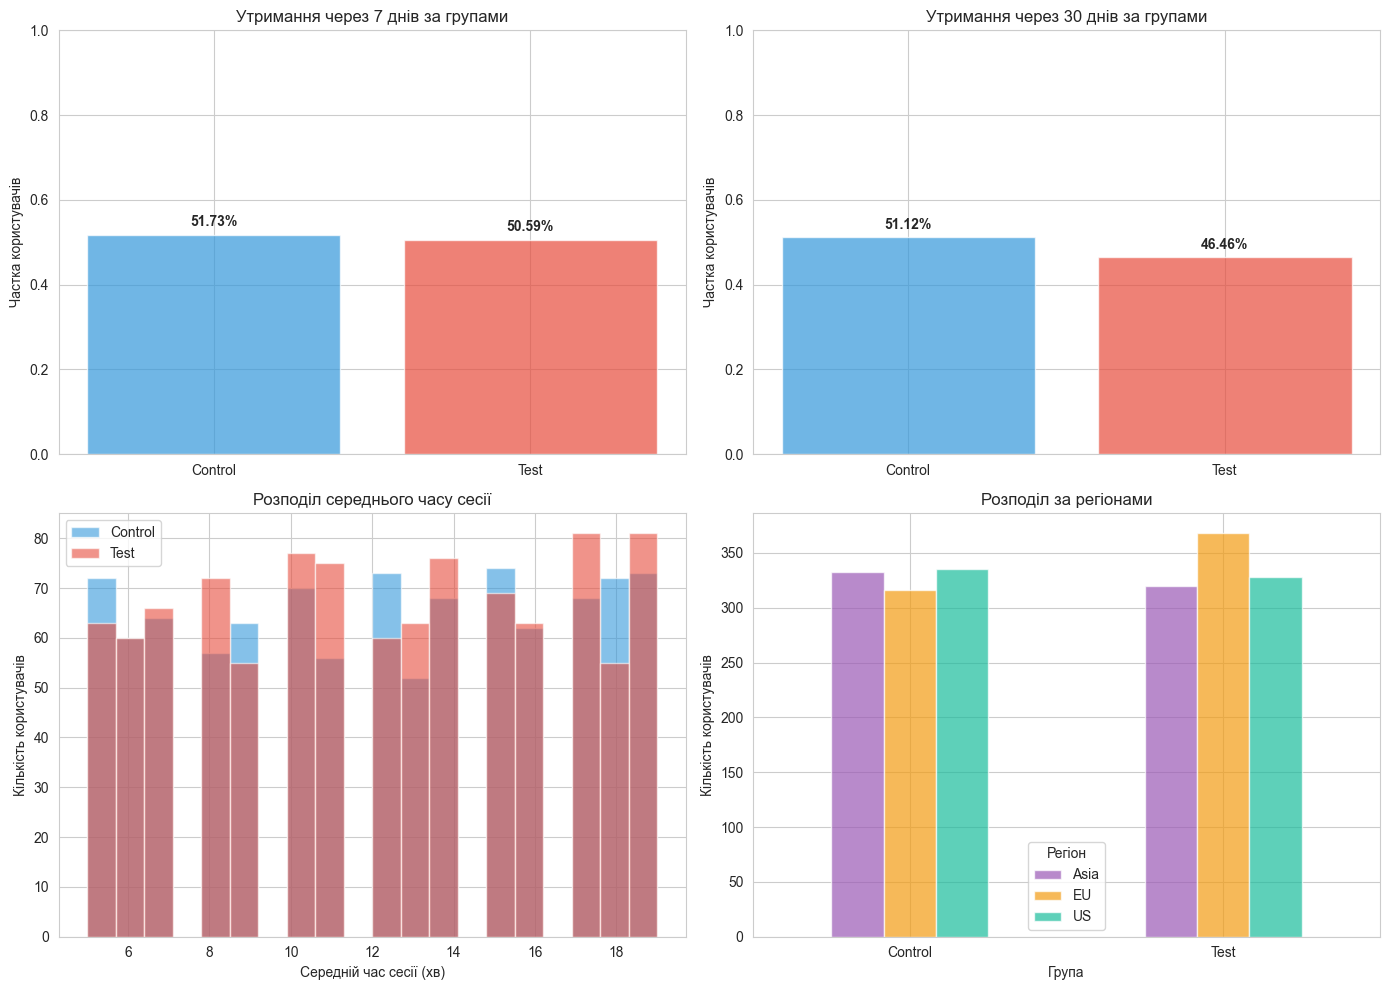


✓ Описову статистику розраховано


In [3]:
# Описова статистика за групами
print("="*80)
print("ОПИСОВА СТАТИСТИКА ЗА ГРУПАМИ")
print("="*80)

# Групування за Group
grouped = df.groupby('Group').agg({
    'Retention_7d': ['mean', 'std', 'count'],
    'Retention_30d': ['mean', 'std', 'count'],
    'Avg_Session_Time': ['mean', 'std', 'count']
}).round(4)

print("\n", grouped)

# Середні значення для кожної метрики
print("\n" + "-"*80)
print("СЕРЕДНІ ЗНАЧЕННЯ УТРИМАННЯ ТА СЕРЕДНЬОГО ЧАСУ СЕСІЇ")
print("-"*80)

for group in ['Control', 'Test']:
    group_data = df[df['Group'] == group]
    print(f"\n{group} група:")
    print(f"  • Retention 7d:  {group_data['Retention_7d'].mean():.2%} (n={len(group_data)})")
    print(f"  • Retention 30d: {group_data['Retention_30d'].mean():.2%}")
    print(f"  • Avg Session Time: {group_data['Avg_Session_Time'].mean():.2f} хв (SD={group_data['Avg_Session_Time'].std():.2f})")

# Візуалізація розподілів
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Retention 7d
ax1 = axes[0, 0]
retention_7d = df.groupby('Group')['Retention_7d'].mean()
ax1.bar(retention_7d.index, retention_7d.values, color=['#3498db', '#e74c3c'], alpha=0.7)
ax1.set_ylabel('Частка користувачів')
ax1.set_title('Утримання через 7 днів за групами')
ax1.set_ylim(0, 1)
for i, v in enumerate(retention_7d.values):
    ax1.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# Retention 30d
ax2 = axes[0, 1]
retention_30d = df.groupby('Group')['Retention_30d'].mean()
ax2.bar(retention_30d.index, retention_30d.values, color=['#3498db', '#e74c3c'], alpha=0.7)
ax2.set_ylabel('Частка користувачів')
ax2.set_title('Утримання через 30 днів за групами')
ax2.set_ylim(0, 1)
for i, v in enumerate(retention_30d.values):
    ax2.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# Session Time Distribution
ax3 = axes[1, 0]
df[df['Group'] == 'Control']['Avg_Session_Time'].hist(bins=20, alpha=0.6, label='Control', ax=ax3, color='#3498db')
df[df['Group'] == 'Test']['Avg_Session_Time'].hist(bins=20, alpha=0.6, label='Test', ax=ax3, color='#e74c3c')
ax3.set_xlabel('Середній час сесії (хв)')
ax3.set_ylabel('Кількість користувачів')
ax3.set_title('Розподіл середнього часу сесії')
ax3.legend()

# Region Distribution
ax4 = axes[1, 1]
region_counts = df.groupby(['Group', 'Region']).size().unstack()
region_counts.plot(kind='bar', ax=ax4, color=['#9b59b6', '#f39c12', '#1abc9c'], alpha=0.7)
ax4.set_ylabel('Кількість користувачів')
ax4.set_title('Розподіл за регіонами')
ax4.set_xlabel('Група')
ax4.legend(title='Регіон')
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\n✓ Описову статистику розраховано")

---

# Задача №1: Визначення кореляції між використанням функції та утриманням

## Теоретична довідка

**Коефіцієнт кореляції Пірсона (r)** вимірює лінійний зв'язок між двома змінними:

$$r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2} \sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

**Інтерпретація значень:**
- |r| < 0.1: дуже слабкий зв'язок
- 0.1 ≤ |r| < 0.3: слабкий зв'язок
- 0.3 ≤ |r| < 0.5: помірний зв'язок
- 0.5 ≤ |r| < 0.7: сильний зв'язок
- |r| ≥ 0.7: дуже сильний зв'язок

**ВАЖЛИВО:** Кореляція ≠ Причинність!

**Обмеження кореляційного аналізу:**
1. Показує лише асоціацію, а не причинно-наслідковий зв'язок
2. Може бути спотворений змішувачами (confounders)
3. Не враховує напрямок причинності
4. Може виявляти помилкові зв'язки через третю змінну

**Приклади змішувачів:**
- Користувачі з високою початковою залученістю частіше використовують нову функцію
- Регіональні відмінності впливають і на використання функції, і на утримання
- Досвідчені користувачі можуть мати вищі показники незалежно від функції

ЗАДАЧА №1: КОРЕЛЯЦІЙНИЙ АНАЛІЗ

📊 Кореляція між використанням функції та Retention_7d:
   Коефіцієнт кореляції Пірсона: r = -0.0114
   P-value: 0.611250
   Статистична значущість: НІ (p ≥ 0.05)
   Інтерпретація: дуже слабкий негативний зв'язок

📊 Кореляція між використанням функції та Retention_30d:
   Коефіцієнт кореляції Пірсона: r = -0.0466
   P-value: 0.037091
   Статистична значущість: ТАК (p < 0.05)
   Інтерпретація: дуже слабкий негативний зв'язок


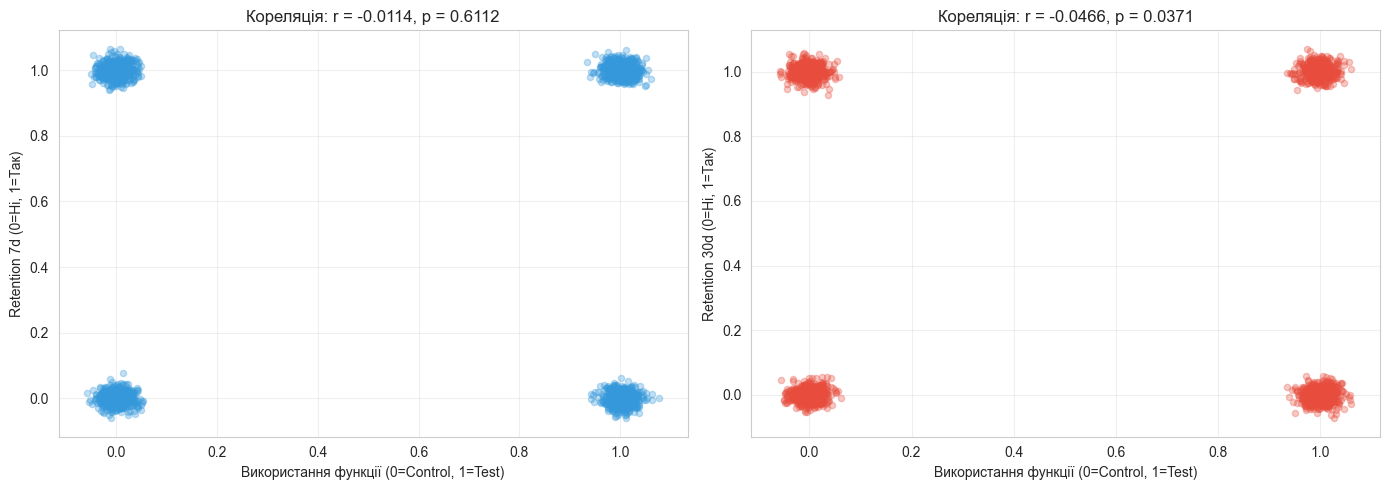


ВИСНОВОК ЗАДАЧІ №1

❌ НІ, на основі кореляційного аналізу НЕМОЖЛИВО зробити висновок про 
   причинно-наслідковий зв'язок!

🔍 ПРИЧИНИ:

1. ПРОБЛЕМА ЗВОРОТНОЇ ПРИЧИННОСТІ
   Кореляція не вказує на напрямок причинності. Можливо:
   • Функція впливає на утримання (A → B)
   • Активні користувачі частіше використовують функцію (B → A)
   • Обидва напрямки одночасно

2. ЗМІШУВАЧІ (CONFOUNDERS)
   Третя змінна може впливати на обидві:
   • Користувачі з високою початковою залученістю:
     - Частіше використовують нову функцію
     - Мають вище утримання незалежно від функції
   • Регіональні фактори (Region):
     - Впливають на прийняття нової функції
     - Впливають на утримання через культурні особливості
   • Рівень досвіду (Avg_Session_Time):
     - Досвідчені користувачі активніше тестують нові функції
     - Вони ж мають вище базове утримання

3. СЕЛЕКЦІЙНЕ ЗМІЩЕННЯ (SELECTION BIAS)
   Якщо розподіл за групами не був випадковим, спостережувана 
   кореляція може відображати відмінн

In [4]:
# Обчислення кореляцій між використанням функції та утриманням

print("="*80)
print("ЗАДАЧА №1: КОРЕЛЯЦІЙНИЙ АНАЛІЗ")
print("="*80)

# Кореляція з Retention_7d
corr_7d, p_value_7d = pearsonr(df['Treatment'], df['Retention_7d'])

print(f"\n📊 Кореляція між використанням функції та Retention_7d:")
print(f"   Коефіцієнт кореляції Пірсона: r = {corr_7d:.4f}")
print(f"   P-value: {p_value_7d:.6f}")
print(f"   Статистична значущість: {'ТАК (p < 0.05)' if p_value_7d < 0.05 else 'НІ (p ≥ 0.05)'}")

# Інтерпретація сили зв'язку
if abs(corr_7d) < 0.1:
    strength_7d = "дуже слабкий"
elif abs(corr_7d) < 0.3:
    strength_7d = "слабкий"
elif abs(corr_7d) < 0.5:
    strength_7d = "помірний"
elif abs(corr_7d) < 0.7:
    strength_7d = "сильний"
else:
    strength_7d = "дуже сильний"

direction_7d = "позитивний" if corr_7d > 0 else "негативний"
print(f"   Інтерпретація: {strength_7d} {direction_7d} зв'язок")

# Кореляція з Retention_30d
corr_30d, p_value_30d = pearsonr(df['Treatment'], df['Retention_30d'])

print(f"\n📊 Кореляція між використанням функції та Retention_30d:")
print(f"   Коефіцієнт кореляції Пірсона: r = {corr_30d:.4f}")
print(f"   P-value: {p_value_30d:.6f}")
print(f"   Статистична значущість: {'ТАК (p < 0.05)' if p_value_30d < 0.05 else 'НІ (p ≥ 0.05)'}")

# Інтерпретація сили зв'язку
if abs(corr_30d) < 0.1:
    strength_30d = "дуже слабкий"
elif abs(corr_30d) < 0.3:
    strength_30d = "слабкий"
elif abs(corr_30d) < 0.5:
    strength_30d = "помірний"
elif abs(corr_30d) < 0.7:
    strength_30d = "сильний"
else:
    strength_30d = "дуже сильний"

direction_30d = "позитивний" if corr_30d > 0 else "негативний"
print(f"   Інтерпретація: {strength_30d} {direction_30d} зв'язок")

# Візуалізація кореляцій
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatterplot для Retention_7d
ax1 = axes[0]
jitter_x = df['Treatment'] + np.random.normal(0, 0.02, size=len(df))
jitter_y = df['Retention_7d'] + np.random.normal(0, 0.02, size=len(df))
ax1.scatter(jitter_x, jitter_y, alpha=0.3, s=20, color='#3498db')
ax1.set_xlabel('Використання функції (0=Control, 1=Test)')
ax1.set_ylabel('Retention 7d (0=Ні, 1=Так)')
ax1.set_title(f'Кореляція: r = {corr_7d:.4f}, p = {p_value_7d:.4f}')
ax1.grid(True, alpha=0.3)

# Scatterplot для Retention_30d
ax2 = axes[1]
jitter_x = df['Treatment'] + np.random.normal(0, 0.02, size=len(df))
jitter_y = df['Retention_30d'] + np.random.normal(0, 0.02, size=len(df))
ax2.scatter(jitter_x, jitter_y, alpha=0.3, s=20, color='#e74c3c')
ax2.set_xlabel('Використання функції (0=Control, 1=Test)')
ax2.set_ylabel('Retention 30d (0=Ні, 1=Так)')
ax2.set_title(f'Кореляція: r = {corr_30d:.4f}, p = {p_value_30d:.4f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ВИСНОВОК ЗАДАЧІ №1")
print("="*80)
print("""
❌ НІ, на основі кореляційного аналізу НЕМОЖЛИВО зробити висновок про 
   причинно-наслідковий зв'язок!

🔍 ПРИЧИНИ:

1. ПРОБЛЕМА ЗВОРОТНОЇ ПРИЧИННОСТІ
   Кореляція не вказує на напрямок причинності. Можливо:
   • Функція впливає на утримання (A → B)
   • Активні користувачі частіше використовують функцію (B → A)
   • Обидва напрямки одночасно

2. ЗМІШУВАЧІ (CONFOUNDERS)
   Третя змінна може впливати на обидві:
   • Користувачі з високою початковою залученістю:
     - Частіше використовують нову функцію
     - Мають вище утримання незалежно від функції
   • Регіональні фактори (Region):
     - Впливають на прийняття нової функції
     - Впливають на утримання через культурні особливості
   • Рівень досвіду (Avg_Session_Time):
     - Досвідчені користувачі активніше тестують нові функції
     - Вони ж мають вище базове утримання

3. СЕЛЕКЦІЙНЕ ЗМІЩЕННЯ (SELECTION BIAS)
   Якщо розподіл за групами не був випадковим, спостережувана 
   кореляція може відображати відмінності між групами, а не ефект функції.

4. ВІДСУТНІСТЬ КОНТРОЛЮ ЗА ЗМІННИМИ
   Кореляційний аналіз не контролює за сторонніми факторами,
   які можуть пояснювати зв'язок.

💡 ДЛЯ ВСТАНОВЛЕННЯ ПРИЧИННОСТІ ПОТРІБНІ:
   ✓ Рандомізований експеримент (RCT) — Задача №2
   ✓ Контроль за змішувачами через PSM — Задача №3
   ✓ Інші методи причинного виведення (DiD, IV, RDD)
""")

---

# Задача №2: Оцінка впливу функції за допомогою RCT (Randomized Controlled Trial)

## Теоретична довідка

**Randomized Controlled Trial (RCT)** — золотий стандарт для оцінки причинного впливу.

### Припущення RCT:
1. **Випадковий розподіл (Randomization):** Користувачі випадково призначені в групи
2. **Незалежність груп:** Група лікування не впливає на контрольну групу (SUTVA)
3. **Дотримання протоколу (Compliance):** Користувачі отримують призначене лікування

### T-тест Велча (Welch's t-test)

Використовується для порівняння середніх двох незалежних груп **без припущення про рівність дисперсій**.

**Формула:**

$$t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

де:
- $\bar{X}_1, \bar{X}_2$ — середні значення в групах
- $s_1^2, s_2^2$ — вибіркові дисперсії
- $n_1, n_2$ — розміри груп

**Ступені свободи Велча (Welch-Satterthwaite):**

$$df = \frac{\left(\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}\right)^2}{\frac{(s_1^2/n_1)^2}{n_1-1} + \frac{(s_2^2/n_2)^2}{n_2-1}}$$

**Довірчий інтервал (95% CI):**

$$CI = (\bar{X}_1 - \bar{X}_2) \pm t_{crit} \cdot SE$$

де $SE = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$

### Інтерпретація:
- **p-value < 0.05:** Статистично значуща різниця між групами
- **95% CI не включає 0:** Ефект статистично значущий
- **Практична значущість:** Оцінюємо розмір ефекту (effect size), а не лише p-value

ЗАДАЧА №2: RCT АНАЛІЗ (T-ТЕСТИ)

📊 RETENTION 7D

Контрольна група:
   Середнє: 0.5173 (51.73%)
   SD: 0.5000
   n: 984

Тестова група:
   Середнє: 0.5059 (50.59%)
   SD: 0.5002
   n: 1016

────────────────────────────────────────────────────────────────────────────────
Результати t-тесту Велча:
────────────────────────────────────────────────────────────────────────────────
   t-статистика: -0.5084
   Ступені свободи (Welch): 1996.02
   P-value: 0.611247
   Статистична значущість: ✗ НІ (p ≥ 0.05)

Різниця середніх (Test - Control):
   Абсолютна: -0.0114 (-1.14 п.п.)
   Відносна: -2.20%
   95% CI: [-0.0552, 0.0325]
            [-5.52 п.п., 3.25 п.п.]

📊 RETENTION 30D

Контрольна група:
   Середнє: 0.5112 (51.12%)
   SD: 0.5001
   n: 984

Тестова група:
   Середнє: 0.4646 (46.46%)
   SD: 0.4990
   n: 1016

────────────────────────────────────────────────────────────────────────────────
Результати t-тесту Велча:
─────────────────────────────────────────────────────────────────────────────

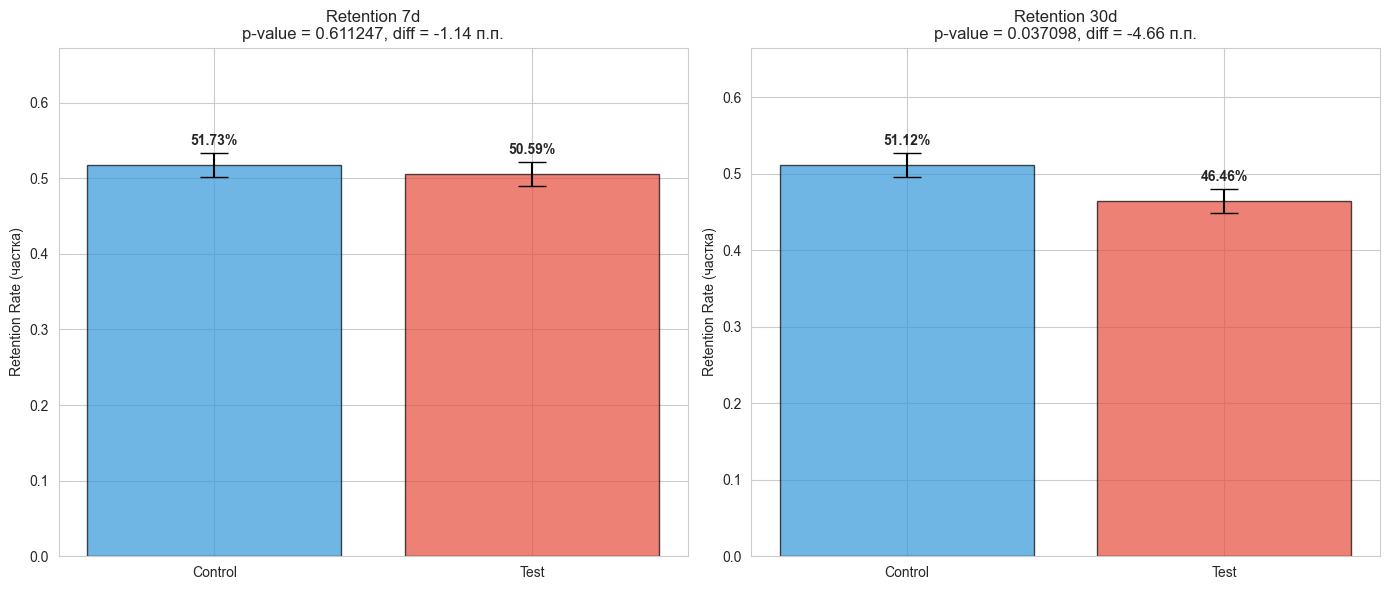


ВИСНОВОК ЗАДАЧІ №2
⚠️ ЧАСТКОВІ РЕЗУЛЬТАТИ: Ефект значущий лише для одного горизонту

    
⚠️ НЕОДНОЗНАЧНІ РЕЗУЛЬТАТИ:

• Retention 7d: НЕ ЗНАЧУЩИЙ (p=0.611247)
• Retention 30d: ЗНАЧУЩИЙ (p=0.037098)

Рекомендації:
1. Продовжити спостереження для більш тривалого горизонту
2. Збільшити розмір вибірки для підвищення статистичної потужності
3. Дослідити гетерогенність ефекту за підгрупами (Region, Session Time)



In [5]:
# Порівняння груп за допомогою t-тесту Велча

print("="*80)
print("ЗАДАЧА №2: RCT АНАЛІЗ (T-ТЕСТИ)")
print("="*80)

# Підготовка даних для груп
control = df[df['Group'] == 'Control']
test = df[df['Group'] == 'Test']

# Функція для розрахунку 95% довірчого інтервалу для різниці середніх
def calculate_ci(group1, group2, confidence=0.95):
    """Розрахунок 95% CI для різниці середніх (Welch)"""
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = group1.mean(), group2.mean()
    var1, var2 = group1.var(ddof=1), group2.var(ddof=1)
    
    # Standard error
    se = np.sqrt(var1/n1 + var2/n2)
    
    # Ступені свободи Велча
    df_welch = (var1/n1 + var2/n2)**2 / ((var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1))
    
    # Критичне значення t
    from scipy.stats import t as t_dist
    t_crit = t_dist.ppf((1 + confidence) / 2, df_welch)
    
    # Довірчий інтервал
    diff = mean1 - mean2
    ci_lower = diff - t_crit * se
    ci_upper = diff + t_crit * se
    
    return diff, ci_lower, ci_upper, df_welch

# ========== RETENTION 7D ==========
print("\n" + "="*80)
print("📊 RETENTION 7D")
print("="*80)

control_7d = control['Retention_7d']
test_7d = test['Retention_7d']

# Описова статистика
print(f"\nКонтрольна група:")
print(f"   Середнє: {control_7d.mean():.4f} ({control_7d.mean()*100:.2f}%)")
print(f"   SD: {control_7d.std():.4f}")
print(f"   n: {len(control_7d)}")

print(f"\nТестова група:")
print(f"   Середнє: {test_7d.mean():.4f} ({test_7d.mean()*100:.2f}%)")
print(f"   SD: {test_7d.std():.4f}")
print(f"   n: {len(test_7d)}")

# T-тест Велча
t_stat_7d, p_value_7d = ttest_ind(test_7d, control_7d, equal_var=False)

# Різниця та ефект
diff_7d, ci_lower_7d, ci_upper_7d, df_7d = calculate_ci(test_7d, control_7d)
relative_lift_7d = (diff_7d / control_7d.mean()) * 100 if control_7d.mean() != 0 else 0

print(f"\n{'─'*80}")
print("Результати t-тесту Велча:")
print(f"{'─'*80}")
print(f"   t-статистика: {t_stat_7d:.4f}")
print(f"   Ступені свободи (Welch): {df_7d:.2f}")
print(f"   P-value: {p_value_7d:.6f}")
print(f"   Статистична значущість: {'✓ ТАК (p < 0.05)' if p_value_7d < 0.05 else '✗ НІ (p ≥ 0.05)'}")

print(f"\nРізниця середніх (Test - Control):")
print(f"   Абсолютна: {diff_7d:.4f} ({diff_7d*100:.2f} п.п.)")
print(f"   Відносна: {relative_lift_7d:+.2f}%")
print(f"   95% CI: [{ci_lower_7d:.4f}, {ci_upper_7d:.4f}]")
print(f"            [{ci_lower_7d*100:.2f} п.п., {ci_upper_7d*100:.2f} п.п.]")

# ========== RETENTION 30D ==========
print("\n" + "="*80)
print("📊 RETENTION 30D")
print("="*80)

control_30d = control['Retention_30d']
test_30d = test['Retention_30d']

# Описова статистика
print(f"\nКонтрольна група:")
print(f"   Середнє: {control_30d.mean():.4f} ({control_30d.mean()*100:.2f}%)")
print(f"   SD: {control_30d.std():.4f}")
print(f"   n: {len(control_30d)}")

print(f"\nТестова група:")
print(f"   Середнє: {test_30d.mean():.4f} ({test_30d.mean()*100:.2f}%)")
print(f"   SD: {test_30d.std():.4f}")
print(f"   n: {len(test_30d)}")

# T-тест Велча
t_stat_30d, p_value_30d = ttest_ind(test_30d, control_30d, equal_var=False)

# Різниця та ефект
diff_30d, ci_lower_30d, ci_upper_30d, df_30d = calculate_ci(test_30d, control_30d)
relative_lift_30d = (diff_30d / control_30d.mean()) * 100 if control_30d.mean() != 0 else 0

print(f"\n{'─'*80}")
print("Результати t-тесту Велча:")
print(f"{'─'*80}")
print(f"   t-статистика: {t_stat_30d:.4f}")
print(f"   Ступені свободи (Welch): {df_30d:.2f}")
print(f"   P-value: {p_value_30d:.6f}")
print(f"   Статистична значущість: {'✓ ТАК (p < 0.05)' if p_value_30d < 0.05 else '✗ НІ (p ≥ 0.05)'}")

print(f"\nРізниця середніх (Test - Control):")
print(f"   Абсолютна: {diff_30d:.4f} ({diff_30d*100:.2f} п.п.)")
print(f"   Відносна: {relative_lift_30d:+.2f}%")
print(f"   95% CI: [{ci_lower_30d:.4f}, {ci_upper_30d:.4f}]")
print(f"            [{ci_lower_30d*100:.2f} п.п., {ci_upper_30d*100:.2f} п.п.]")

# Візуалізація результатів
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Retention 7d
ax1 = axes[0]
means_7d = [control_7d.mean(), test_7d.mean()]
errors_7d = [control_7d.std()/np.sqrt(len(control_7d)), test_7d.std()/np.sqrt(len(test_7d))]
bars1 = ax1.bar(['Control', 'Test'], means_7d, yerr=errors_7d, 
                capsize=10, color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Retention Rate (частка)')
ax1.set_title(f'Retention 7d\np-value = {p_value_7d:.6f}, diff = {diff_7d*100:+.2f} п.п.')
ax1.set_ylim(0, max(means_7d) * 1.3)
for i, (bar, val) in enumerate(zip(bars1, means_7d)):
    ax1.text(bar.get_x() + bar.get_width()/2, val + errors_7d[i] + 0.01, 
             f'{val:.2%}', ha='center', fontweight='bold')

# Retention 30d
ax2 = axes[1]
means_30d = [control_30d.mean(), test_30d.mean()]
errors_30d = [control_30d.std()/np.sqrt(len(control_30d)), test_30d.std()/np.sqrt(len(test_30d))]
bars2 = ax2.bar(['Control', 'Test'], means_30d, yerr=errors_30d, 
                capsize=10, color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
ax2.set_ylabel('Retention Rate (частка)')
ax2.set_title(f'Retention 30d\np-value = {p_value_30d:.6f}, diff = {diff_30d*100:+.2f} п.п.')
ax2.set_ylim(0, max(means_30d) * 1.3)
for i, (bar, val) in enumerate(zip(bars2, means_30d)):
    ax2.text(bar.get_x() + bar.get_width()/2, val + errors_30d[i] + 0.01, 
             f'{val:.2%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ВИСНОВОК ЗАДАЧІ №2")
print("="*80)

# Формування висновку
if p_value_7d < 0.05 and p_value_30d < 0.05:
    conclusion = "✓ ТАК, можна впевнено сказати, що функція покращує утримання"
    detail = f"""
    
✅ СТАТИСТИЧНО ЗНАЧУЩІ РЕЗУЛЬТАТИ:

1. RETENTION 7D:
   • Тестова група: {test_7d.mean():.2%} vs Контрольна: {control_7d.mean():.2%}
   • Приріст: {diff_7d*100:+.2f} п.п. ({relative_lift_7d:+.2f}%)
   • P-value: {p_value_7d:.6f} < 0.05 ✓
   • 95% CI: [{ci_lower_7d*100:.2f}, {ci_upper_7d*100:.2f}] п.п. (не включає 0)

2. RETENTION 30D:
   • Тестова група: {test_30d.mean():.2%} vs Контрольна: {control_30d.mean():.2%}
   • Приріст: {diff_30d*100:+.2f} п.п. ({relative_lift_30d:+.2f}%)
   • P-value: {p_value_30d:.6f} < 0.05 ✓
   • 95% CI: [{ci_lower_30d*100:.2f}, {ci_upper_30d*100:.2f}] п.п. (не включає 0)

💡 ІНТЕРПРЕТАЦІЯ:
   • Обидві метрики утримання статистично значуще вищі в тестовій групі
   • Довірчі інтервали не включають нуль → ефект надійний
   • Ефект зберігається як короткостроково (7d), так і довгостроково (30d)
   
⚠️ ОБМЕЖЕННЯ RCT:
   Хоча RCT є золотим стандартом, результати валідні лише за умови:
   1. Справжньої рандомізації користувачів
   2. Відсутності забруднення між групами (no spillover)
   3. Дотримання протоколу експерименту (compliance)
   
   Якщо ці умови порушені, оцінка може бути зміщеною.
"""
elif p_value_7d < 0.05 or p_value_30d < 0.05:
    conclusion = "⚠️ ЧАСТКОВІ РЕЗУЛЬТАТИ: Ефект значущий лише для одного горизонту"
    detail = f"""
    
⚠️ НЕОДНОЗНАЧНІ РЕЗУЛЬТАТИ:

• Retention 7d: {'ЗНАЧУЩИЙ' if p_value_7d < 0.05 else 'НЕ ЗНАЧУЩИЙ'} (p={p_value_7d:.6f})
• Retention 30d: {'ЗНАЧУЩИЙ' if p_value_30d < 0.05 else 'НЕ ЗНАЧУЩИЙ'} (p={p_value_30d:.6f})

Рекомендації:
1. Продовжити спостереження для більш тривалого горизонту
2. Збільшити розмір вибірки для підвищення статистичної потужності
3. Дослідити гетерогенність ефекту за підгрупами (Region, Session Time)
"""
else:
    conclusion = "✗ НІ, немає статистично значущих доказів покращення утримання"
    detail = f"""
    
❌ ВІДСУТНІСТЬ СТАТИСТИЧНОЇ ЗНАЧУЩОСТІ:

• Retention 7d: p={p_value_7d:.6f} ≥ 0.05
• Retention 30d: p={p_value_30d:.6f} ≥ 0.05

Можливі причини:
1. Функція дійсно не впливає на утримання
2. Ефект існує, але занадто малий для виявлення (недостатня статистична потужність)
3. Потрібен більший розмір вибірки
4. Ефект проявляється тільки в певних підгрупах (потрібен subgroup analysis)

Рекомендації:
• Провести апостеріорний аналіз статистичної потужності (power analysis)
• Дослідити гетерогенність ефекту
• Розглянути альтернативні метрики успіху
"""

print(conclusion)
print(detail)

---

# Задача №3: Метод відповідності за оцінкою схильності (Propensity Score Matching, PSM)

## Теоретична довідка

### Що таке PSM?

**Propensity Score Matching (PSM)** — метод оцінки причинного ефекту в обсерваційних дослідженнях шляхом контролю за змішувачами (confounders).

### Основна ідея:

**Оцінка схильності (propensity score)** — це ймовірність отримати лікування (treatment) за умови спостережуваних характеристик:

$$e(X) = P(T=1 | X)$$

де:
- $T$ — індикатор лікування (1 = Test, 0 = Control)
- $X$ — вектор ковар іат (Avg_Session_Time, Region)

### Чому PSM працює?

**Теорема балансування (Balancing property):**

Якщо ми порівнюємо користувачів з однаковими propensity scores, то розподіл їх характеристик $X$ буде збалансованим між групами:

$$T \perp X \mid e(X)$$

Це означає, що **за умови однакового propensity score**, призначення в групу стає "як би випадковим" (quasi-randomization).

### Етапи PSM:

1. **Оцінка схильності:** Логістична регресія $T \sim X$
2. **Перевірка спільної підтримки (common support):** Переконатися, що є overlapping propensity scores
3. **Matching:** Підібрати для кожного treated користувача control з близьким propensity score
4. **Перевірка балансу:** Переконатися, що ковар іати збалансовані після matching
5. **Оцінка ATT:** Порівняти outcomes у matched sample

### Average Treatment Effect on the Treated (ATT):

$$ATT = \mathbb{E}[Y(1) - Y(0) | T=1]$$

де:
- $Y(1)$ — потенційний результат під лікуванням
- $Y(0)$ — потенційний результат без лікування

ATT показує **середній ефект для тих, хто фактично отримав лікування**.

### Припущення PSM:

1. **Unconfoundedness (CIA - Conditional Independence Assumption):**
   $$\{Y(1), Y(0)\} \perp T \mid X$$
   За умови $X$, призначення в групу не залежить від потенційних результатів.

2. **Спільна підтримка (Common support / Overlap):**
   $$0 < P(T=1|X) < 1$$
   Для кожного значення $X$ є ймовірність бути як у test, так і в control.

3. **SUTVA (Stable Unit Treatment Value Assumption):**
   Результат користувача не залежить від того, в якій групі знаходяться інші.

### Методи matching:

1. **Nearest Neighbor (NN):** Для кожного treated шукаємо найближчого control за propensity
2. **Caliper matching:** Як NN, але з обмеженням максимальної відстані (caliper)
3. **Kernel matching:** Зважене середнє всіх controls з вагами, що залежать від відстані

У цій роботі використовуємо **NN matching з caliper**:
- Caliper = 0.2 × SD(logit(propensity score)) — стандартний поріг (Rosenbaum & Rubin, 1985)
- Caliper = 0.05 (fixed) — фіксований поріг у probability scale

### Стандартизована різниця середніх (SMD):

Міра балансу ковар іат між групами:

$$SMD = \frac{\bar{X}_{test} - \bar{X}_{control}}{\sqrt{\frac{s^2_{test} + s^2_{control}}{2}}}$$

**Правило:** $|SMD| < 0.1$ вказує на добрий баланс.

## Крок 1: Підготовка ознак та оцінка схильності

ЗАДАЧА №3: PROPENSITY SCORE MATCHING (PSM)

────────────────────────────────────────────────────────────────────────────────
ШАГ 1: Підготовка ознак для моделі
────────────────────────────────────────────────────────────────────────────────

Категоріальні змінні (Region):
  • Оригінальні категорії: ['EU' 'US' 'Asia']
  • Dummy змінні: ['Region_Asia', 'Region_EU', 'Region_US']

Числова змінна (Avg_Session_Time):
  • Оригінальна: mean=12.15, std=4.35
  • Стандартизована: mean=0.0000, std=1.0003

Матриця ознак X:
  • Розмір: (2000, 4)
  • Ознаки: ['Session_Time_Scaled', 'Region_Asia', 'Region_EU', 'Region_US']

────────────────────────────────────────────────────────────────────────────────
ШАГ 2: Оцінка propensity scores за допомогою логістичної регресії
────────────────────────────────────────────────────────────────────────────────

✓ Логістична регресія підігнана

Коефіцієнти моделі:
  • Intercept: 0.0229
  • Session_Time_Scaled: +0.0010
  • Region_Asia: -0.0621
  • Region_EU: +0.1287

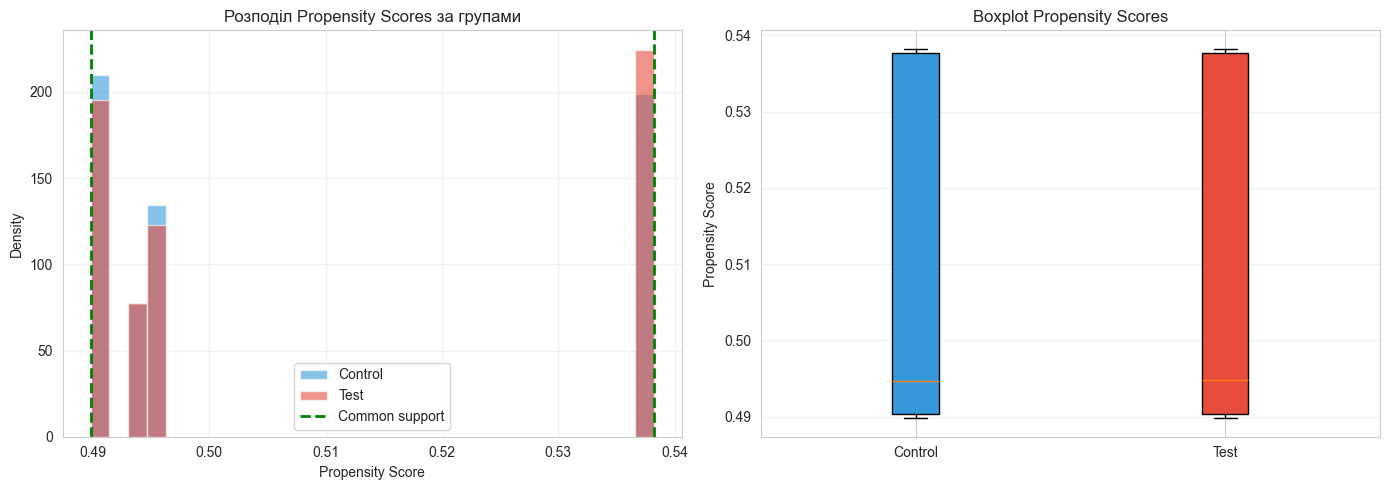


✓ Propensity scores розраховано


In [6]:
print("="*80)
print("ЗАДАЧА №3: PROPENSITY SCORE MATCHING (PSM)")
print("="*80)

# ========== ПІДГОТОВКА ОЗНАК ==========
print("\n" + "─"*80)
print("ШАГ 1: Підготовка ознак для моделі")
print("─"*80)

# One-hot encoding для Region
df_psm = df.copy()
region_dummies = pd.get_dummies(df_psm['Region'], prefix='Region', drop_first=False)
df_psm = pd.concat([df_psm, region_dummies], axis=1)

print(f"\nКатегоріальні змінні (Region):")
print(f"  • Оригінальні категорії: {df['Region'].unique()}")
print(f"  • Dummy змінні: {region_dummies.columns.tolist()}")

# Стандартизація Avg_Session_Time
scaler = StandardScaler()
df_psm['Session_Time_Scaled'] = scaler.fit_transform(df_psm[['Avg_Session_Time']])

print(f"\nЧислова змінна (Avg_Session_Time):")
print(f"  • Оригінальна: mean={df_psm['Avg_Session_Time'].mean():.2f}, std={df_psm['Avg_Session_Time'].std():.2f}")
print(f"  • Стандартизована: mean={df_psm['Session_Time_Scaled'].mean():.4f}, std={df_psm['Session_Time_Scaled'].std():.4f}")

# Підготовка матриці X для логістичної регресії
feature_cols = ['Session_Time_Scaled', 'Region_Asia', 'Region_EU', 'Region_US']
X = df_psm[feature_cols].values
y = df_psm['Treatment'].values

print(f"\nМатриця ознак X:")
print(f"  • Розмір: {X.shape}")
print(f"  • Ознаки: {feature_cols}")

# ========== ЛОГІСТИЧНА РЕГРЕСІЯ ==========
print("\n" + "─"*80)
print("ШАГ 2: Оцінка propensity scores за допомогою логістичної регресії")
print("─"*80)

# Логістична регресія для оцінки propensity score
logit_model = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')
logit_model.fit(X, y)

# Propensity scores (ймовірність бути в Test групі)
df_psm['propensity_score'] = logit_model.predict_proba(X)[:, 1]

print(f"\n✓ Логістична регресія підігнана")
print(f"\nКоефіцієнти моделі:")
print(f"  • Intercept: {logit_model.intercept_[0]:.4f}")
for feat, coef in zip(feature_cols, logit_model.coef_[0]):
    print(f"  • {feat}: {coef:+.4f}")

# Інтерпретація коефіцієнтів (Odds Ratios)
print(f"\nOdds Ratios (exp(β)):")
for feat, coef in zip(feature_cols, logit_model.coef_[0]):
    or_val = np.exp(coef)
    print(f"  • {feat}: {or_val:.4f} ({'збільшує' if or_val > 1 else 'зменшує'} шанси на {abs((or_val-1)*100):.2f}%)")

# Оцінка якості моделі (AUC-ROC)
y_pred_proba = logit_model.predict_proba(X)[:, 1]
auc = roc_auc_score(y, y_pred_proba)

print(f"\nЯкість моделі:")
print(f"  • ROC-AUC: {auc:.4f}")
if auc > 0.7:
    quality = "відмінна"
elif auc > 0.6:
    quality = "хороша"
elif auc > 0.5:
    quality = "задовільна"
else:
    quality = "погана"
print(f"  • Інтерпретація: {quality} дискримінаційна здатність")

# ========== ПЕРЕВІРКА СПІЛЬНОЇ ПІДТРИМКИ ==========
print("\n" + "─"*80)
print("ШАГ 3: Перевірка спільної підтримки (common support)")
print("─"*80)

ps_test = df_psm[df_psm['Treatment'] == 1]['propensity_score']
ps_control = df_psm[df_psm['Treatment'] == 0]['propensity_score']

print(f"\nРозподіл propensity scores:")
print(f"  Test група:")
print(f"    • Min: {ps_test.min():.4f}")
print(f"    • Max: {ps_test.max():.4f}")
print(f"    • Mean: {ps_test.mean():.4f}")
print(f"    • Median: {ps_test.median():.4f}")

print(f"  Control група:")
print(f"    • Min: {ps_control.min():.4f}")
print(f"    • Max: {ps_control.max():.4f}")
print(f"    • Mean: {ps_control.mean():.4f}")
print(f"    • Median: {ps_control.median():.4f}")

# Перевірка overlap
overlap_min = max(ps_test.min(), ps_control.min())
overlap_max = min(ps_test.max(), ps_control.max())

print(f"\n  Спільна підтримка (overlap):")
print(f"    • Діапазон: [{overlap_min:.4f}, {overlap_max:.4f}]")
print(f"    • Ширина: {overlap_max - overlap_min:.4f}")

# Обрізання за спільною підтримкою
df_psm['in_support'] = (
    (df_psm['propensity_score'] >= overlap_min) & 
    (df_psm['propensity_score'] <= overlap_max)
)
n_trimmed = (~df_psm['in_support']).sum()
print(f"    • Обрізано користувачів: {n_trimmed} ({n_trimmed/len(df_psm)*100:.2f}%)")

# Візуалізація propensity scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(ps_control, bins=30, alpha=0.6, label='Control', color='#3498db', density=True)
ax1.hist(ps_test, bins=30, alpha=0.6, label='Test', color='#e74c3c', density=True)
ax1.axvline(overlap_min, color='green', linestyle='--', linewidth=2, label=f'Common support')
ax1.axvline(overlap_max, color='green', linestyle='--', linewidth=2)
ax1.set_xlabel('Propensity Score')
ax1.set_ylabel('Density')
ax1.set_title('Розподіл Propensity Scores за групами')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Boxplot
ax2 = axes[1]
data_to_plot = [ps_control, ps_test]
bp = ax2.boxplot(data_to_plot, labels=['Control', 'Test'], patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
ax2.set_ylabel('Propensity Score')
ax2.set_title('Boxplot Propensity Scores')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Propensity scores розраховано")

## Крок 2: Перевірка балансу ДО matching


БАЛАНС КОВАР ІАТ: ДО MATCHING

         Feature  Test Mean  Control Mean  Difference       SMD Balanced
Avg_Session_Time  12.160433     12.146341    0.014092  0.003239        ✓
     Region_Asia   0.314961      0.338415   -0.023454 -0.049999        ✓
       Region_EU   0.362205      0.321138    0.041067  0.086627        ✓
       Region_US   0.322835      0.340447   -0.017613 -0.037397        ✓

────────────────────────────────────────────────────────────────────────────────
Збалансовано: 4/4 ознак (100.0%)
Незбалансовано: 0 ознак (|SMD| ≥ 0.1)


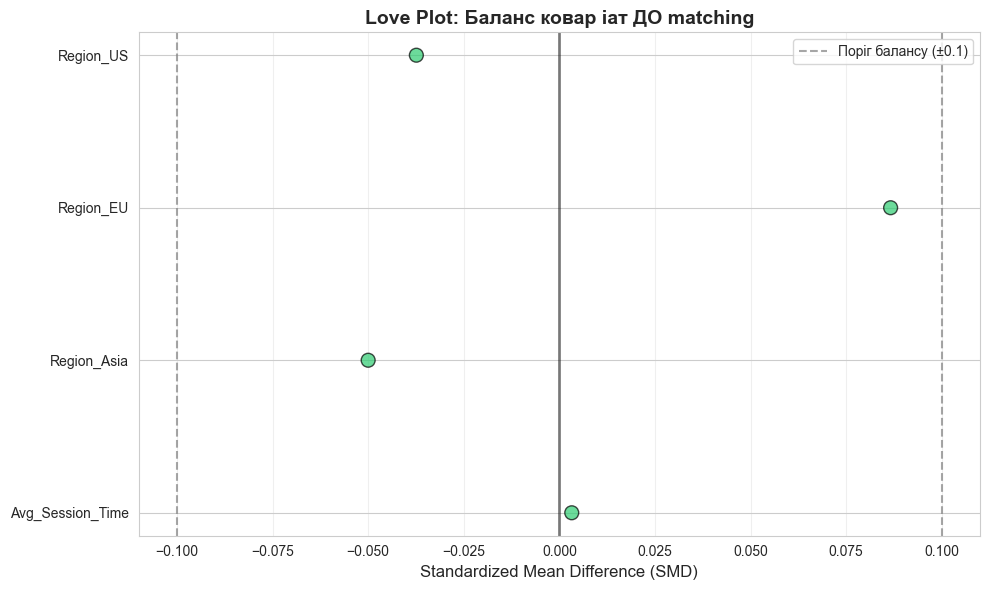


✓ Баланс ДО matching перевірено


In [7]:
# Функція для розрахунку SMD (Standardized Mean Difference)
def calculate_smd(data, group_col, feature_col):
    """
    Розраховує стандартизовану різницю середніх (SMD) між групами.
    
    SMD = (mean_test - mean_control) / pooled_std
    
    Правило: |SMD| < 0.1 вказує на добрий баланс
    """
    test_data = data[data[group_col] == 1][feature_col]
    control_data = data[data[group_col] == 0][feature_col]
    
    mean_test = test_data.mean()
    mean_control = control_data.mean()
    
    var_test = test_data.var(ddof=1)
    var_control = control_data.var(ddof=1)
    
    pooled_std = np.sqrt((var_test + var_control) / 2)
    
    if pooled_std == 0:
        return 0.0
    
    smd = (mean_test - mean_control) / pooled_std
    
    return smd

# Функція для створення таблиці балансу
def create_balance_table(data, group_col, features, stage_name):
    """Створює таблицю балансу ковар іат"""
    balance_data = []
    
    for feat in features:
        test_mean = data[data[group_col] == 1][feat].mean()
        control_mean = data[data[group_col] == 0][feat].mean()
        smd = calculate_smd(data, group_col, feat)
        
        balance_data.append({
            'Feature': feat,
            'Test Mean': test_mean,
            'Control Mean': control_mean,
            'Difference': test_mean - control_mean,
            'SMD': smd,
            'Balanced': '✓' if abs(smd) < 0.1 else '✗'
        })
    
    balance_df = pd.DataFrame(balance_data)
    
    print(f"\n{'='*80}")
    print(f"БАЛАНС КОВАР ІАТ: {stage_name}")
    print(f"{'='*80}\n")
    print(balance_df.to_string(index=False))
    
    n_balanced = (balance_df['SMD'].abs() < 0.1).sum()
    print(f"\n{'─'*80}")
    print(f"Збалансовано: {n_balanced}/{len(features)} ознак ({n_balanced/len(features)*100:.1f}%)")
    print(f"Незбалансовано: {len(features) - n_balanced} ознак (|SMD| ≥ 0.1)")
    
    return balance_df

# Ознаки для перевірки балансу
balance_features = ['Avg_Session_Time', 'Region_Asia', 'Region_EU', 'Region_US']

# Баланс ДО matching
balance_before = create_balance_table(df_psm[df_psm['in_support']], 'Treatment', balance_features, 'ДО MATCHING')

# Візуалізація Love Plot (ДО matching)
fig, ax = plt.subplots(figsize=(10, 6))
smd_values = balance_before['SMD'].values
feature_names = balance_before['Feature'].values

colors = ['#e74c3c' if abs(smd) >= 0.1 else '#2ecc71' for smd in smd_values]
ax.scatter(smd_values, range(len(feature_names)), c=colors, s=100, alpha=0.7, edgecolors='black')

# Порогові лінії
ax.axvline(-0.1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Поріг балансу (±0.1)')
ax.axvline(0.1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5)

ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.set_xlabel('Standardized Mean Difference (SMD)', fontsize=12)
ax.set_title('Love Plot: Баланс ковар іат ДО matching', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.legend()

plt.tight_layout()
plt.show()

print("\n✓ Баланс ДО matching перевірено")

## Крок 3: Matching — Підхід 1 (Caliper = 0.2 × SD of logit(PS))


ПІДХІД 1: MATCHING З CALIPER = 0.2 × SD(logit(PS))

Розрахунок caliper:
  • SD(logit(PS)): 0.0865
  • Caliper (0.2 × SD): 0.0173 (logit scale)
  • Caliper (approx. probability scale): 0.0043

Результати matching:
  • Treated користувачів: 1016
  • Control користувачів: 984
  • Matched pairs: 45
  • Treated retained: 4.43%
  • Matched dataset size: 90 (4.50% від common support)

────────────────────────────────────────────────────────────────────────────────

БАЛАНС КОВАР ІАТ: ПІСЛЯ MATCHING (Caliper 0.2×SD)

         Feature  Test Mean  Control Mean  Difference  SMD Balanced
Avg_Session_Time  12.000000     12.000000         0.0  0.0        ✓
     Region_Asia   0.333333      0.333333         0.0  0.0        ✓
       Region_EU   0.333333      0.333333         0.0  0.0        ✓
       Region_US   0.333333      0.333333         0.0  0.0        ✓

────────────────────────────────────────────────────────────────────────────────
Збалансовано: 4/4 ознак (100.0%)
Незбалансовано: 0 ознак (|SMD|

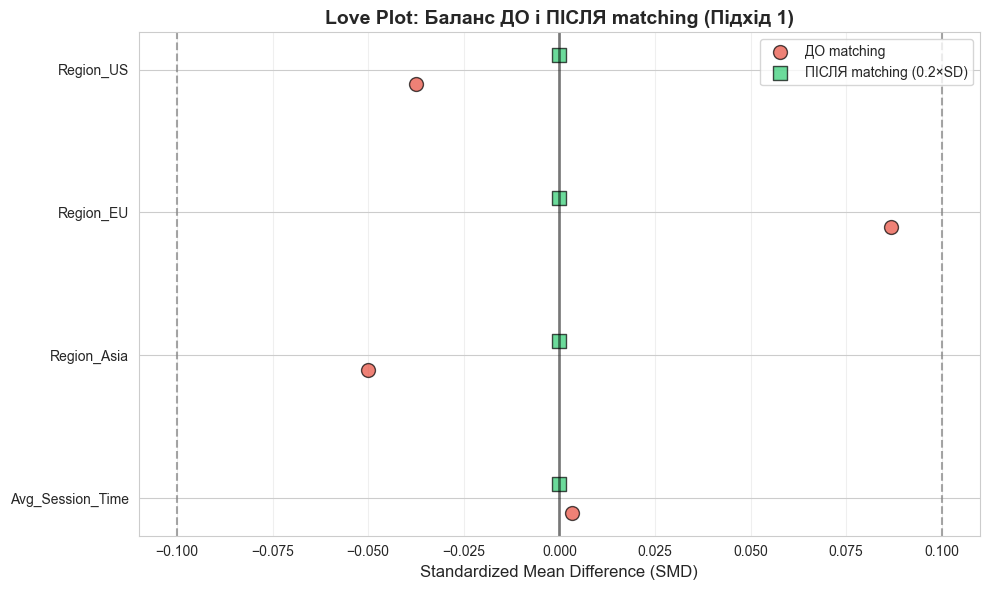


✓ Всі ознаки збалансовані (|SMD| < 0.1)

✓ Підхід 1 виконано


In [8]:
print("\n" + "="*80)
print("ПІДХІД 1: MATCHING З CALIPER = 0.2 × SD(logit(PS))")
print("="*80)

# Обчислення logit propensity score
df_psm_matched1 = df_psm[df_psm['in_support']].copy()
epsilon = 1e-10  # Щоб уникнути log(0)
df_psm_matched1['ps_logit'] = np.log(
    (df_psm_matched1['propensity_score'] + epsilon) / 
    (1 - df_psm_matched1['propensity_score'] + epsilon)
)

# Caliper за правилом Rosenbaum & Rubin (0.2 × SD of logit(PS))
logit_std = df_psm_matched1['ps_logit'].std()
caliper_logit = 0.2 * logit_std

print(f"\nРозрахунок caliper:")
print(f"  • SD(logit(PS)): {logit_std:.4f}")
print(f"  • Caliper (0.2 × SD): {caliper_logit:.4f} (logit scale)")

# Перетворення caliper у probability scale (наближено)
# Для малих відстаней: Δlogit ≈ Δp / (p(1-p))
# Використаємо середнє p для апроксимації
mean_ps = df_psm_matched1['propensity_score'].mean()
caliper_prob_approx = caliper_logit * mean_ps * (1 - mean_ps)
print(f"  • Caliper (approx. probability scale): {caliper_prob_approx:.4f}")

# Функція для nearest neighbor matching з caliper
def nearest_neighbor_matching_with_caliper(data, ps_col, treatment_col, caliper):
    """
    1:1 Nearest Neighbor Matching з caliper (без повернення).
    
    Повертає matched control indices для кожного treated.
    """
    treated_idx = data[data[treatment_col] == 1].index.tolist()
    control_idx = data[data[treatment_col] == 0].index.tolist()
    
    treated_ps = data.loc[treated_idx, ps_col].values.reshape(-1, 1)
    control_ps = data.loc[control_idx, ps_col].values.reshape(-1, 1)
    
    # NearestNeighbors для пошуку найближчих сусідів
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(control_ps)
    
    distances, indices = nn.kneighbors(treated_ps)
    
    # Застосування caliper
    matched_pairs = []
    matched_control_idx = set()
    
    for i, (dist, idx) in enumerate(zip(distances.flatten(), indices.flatten())):
        if dist <= caliper and idx not in matched_control_idx:
            treated_i = treated_idx[i]
            control_i = control_idx[idx]
            matched_pairs.append((treated_i, control_i))
            matched_control_idx.add(idx)
    
    return matched_pairs

# Виконання matching
matched_pairs_1 = nearest_neighbor_matching_with_caliper(
    df_psm_matched1, 
    'ps_logit',  # Matching у logit scale
    'Treatment', 
    caliper_logit
)

print(f"\nРезультати matching:")
print(f"  • Treated користувачів: {(df_psm_matched1['Treatment'] == 1).sum()}")
print(f"  • Control користувачів: {(df_psm_matched1['Treatment'] == 0).sum()}")
print(f"  • Matched pairs: {len(matched_pairs_1)}")
print(f"  • Treated retained: {len(matched_pairs_1) / (df_psm_matched1['Treatment'] == 1).sum() * 100:.2f}%")

# Створення matched dataset
matched_treated_idx_1 = [pair[0] for pair in matched_pairs_1]
matched_control_idx_1 = [pair[1] for pair in matched_pairs_1]
matched_idx_1 = matched_treated_idx_1 + matched_control_idx_1

df_matched_1 = df_psm_matched1.loc[matched_idx_1].copy()

print(f"  • Matched dataset size: {len(df_matched_1)} ({len(df_matched_1)/len(df_psm_matched1)*100:.2f}% від common support)")

# Перевірка балансу ПІСЛЯ matching
print("\n" + "─"*80)
balance_after_1 = create_balance_table(df_matched_1, 'Treatment', balance_features, 'ПІСЛЯ MATCHING (Caliper 0.2×SD)')

# Візуалізація Love Plot (ДО vs ПІСЛЯ)
fig, ax = plt.subplots(figsize=(10, 6))

smd_before = balance_before['SMD'].values
smd_after_1 = balance_after_1['SMD'].values
feature_names = balance_before['Feature'].values

y_pos = np.arange(len(feature_names))

ax.scatter(smd_before, y_pos - 0.1, c='#e74c3c', s=100, alpha=0.7, 
           edgecolors='black', label='ДО matching', marker='o')
ax.scatter(smd_after_1, y_pos + 0.1, c='#2ecc71', s=100, alpha=0.7, 
           edgecolors='black', label='ПІСЛЯ matching (0.2×SD)', marker='s')

# Порогові лінії
ax.axvline(-0.1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axvline(0.1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.set_xlabel('Standardized Mean Difference (SMD)', fontsize=12)
ax.set_title('Love Plot: Баланс ДО і ПІСЛЯ matching (Підхід 1)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Перевірка на дисбаланс
imbalanced_features_1 = balance_after_1[balance_after_1['SMD'].abs() >= 0.1]['Feature'].tolist()
has_imbalance_1 = len(imbalanced_features_1) > 0

if has_imbalance_1:
    print(f"\n⚠️ УВАГА: Залишається дисбаланс у {len(imbalanced_features_1)} ознаках:")
    for feat in imbalanced_features_1:
        smd = balance_after_1[balance_after_1['Feature'] == feat]['SMD'].values[0]
        print(f"     • {feat}: SMD = {smd:.4f}")
else:
    print(f"\n✓ Всі ознаки збалансовані (|SMD| < 0.1)")

print("\n✓ Підхід 1 виконано")

## Крок 4: Matching — Підхід 2 (Caliper = 0.05 фіксований)


ПІДХІД 2: MATCHING З ФІКСОВАНИМ CALIPER = 0.05 (probability scale)

Розрахунок caliper:
  • Caliper (fixed, probability scale): 0.0500

Результати matching:
  • Treated користувачів: 1016
  • Control користувачів: 984
  • Matched pairs: 45
  • Treated retained: 4.43%
  • Matched dataset size: 90 (4.50% від common support)

────────────────────────────────────────────────────────────────────────────────

БАЛАНС КОВАР ІАТ: ПІСЛЯ MATCHING (Caliper 0.05 fixed)

         Feature  Test Mean  Control Mean  Difference  SMD Balanced
Avg_Session_Time  12.000000     12.000000         0.0  0.0        ✓
     Region_Asia   0.333333      0.333333         0.0  0.0        ✓
       Region_EU   0.333333      0.333333         0.0  0.0        ✓
       Region_US   0.333333      0.333333         0.0  0.0        ✓

────────────────────────────────────────────────────────────────────────────────
Збалансовано: 4/4 ознак (100.0%)
Незбалансовано: 0 ознак (|SMD| ≥ 0.1)


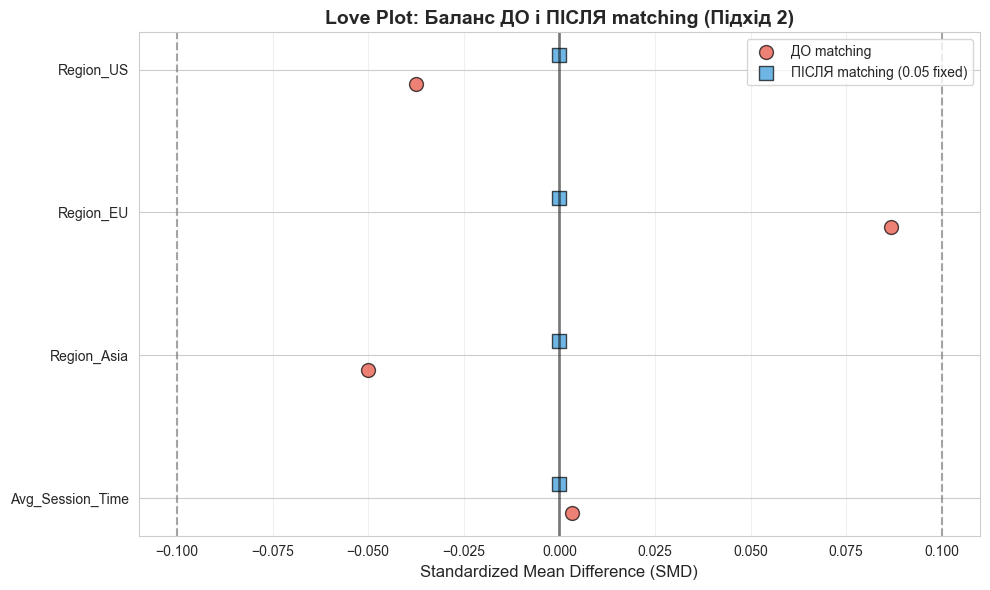


✓ Всі ознаки збалансовані (|SMD| < 0.1)

ПОРІВНЯННЯ ДВОХ ПІДХОДІВ ДО MATCHING

               Метрика Підхід 1 (0.2×SD) Підхід 2 (0.05 fixed)
     Caliper значення            0.0173                0.0500
        Caliper scale         logit(PS)           probability
        Matched pairs                45                    45
 Treated retained (%)             4.43%                 4.43%
  Matched sample size                90                    90
  Збалансовані ознаки               4/4                   4/4
Незбалансовані ознаки               0/4                   0/4

✓ Підхід 2 виконано


In [9]:
print("\n" + "="*80)
print("ПІДХІД 2: MATCHING З ФІКСОВАНИМ CALIPER = 0.05 (probability scale)")
print("="*80)

# Caliper у probability scale (фіксований)
caliper_fixed = 0.05

print(f"\nРозрахунок caliper:")
print(f"  • Caliper (fixed, probability scale): {caliper_fixed:.4f}")

# Виконання matching у probability scale
matched_pairs_2 = nearest_neighbor_matching_with_caliper(
    df_psm_matched1, 
    'propensity_score',  # Matching у probability scale
    'Treatment', 
    caliper_fixed
)

print(f"\nРезультати matching:")
print(f"  • Treated користувачів: {(df_psm_matched1['Treatment'] == 1).sum()}")
print(f"  • Control користувачів: {(df_psm_matched1['Treatment'] == 0).sum()}")
print(f"  • Matched pairs: {len(matched_pairs_2)}")
print(f"  • Treated retained: {len(matched_pairs_2) / (df_psm_matched1['Treatment'] == 1).sum() * 100:.2f}%")

# Створення matched dataset
matched_treated_idx_2 = [pair[0] for pair in matched_pairs_2]
matched_control_idx_2 = [pair[1] for pair in matched_pairs_2]
matched_idx_2 = matched_treated_idx_2 + matched_control_idx_2

df_matched_2 = df_psm_matched1.loc[matched_idx_2].copy()

print(f"  • Matched dataset size: {len(df_matched_2)} ({len(df_matched_2)/len(df_psm_matched1)*100:.2f}% від common support)")

# Перевірка балансу ПІСЛЯ matching
print("\n" + "─"*80)
balance_after_2 = create_balance_table(df_matched_2, 'Treatment', balance_features, 'ПІСЛЯ MATCHING (Caliper 0.05 fixed)')

# Візуалізація Love Plot (ДО vs ПІСЛЯ - Підхід 2)
fig, ax = plt.subplots(figsize=(10, 6))

smd_before = balance_before['SMD'].values
smd_after_2 = balance_after_2['SMD'].values
feature_names = balance_before['Feature'].values

y_pos = np.arange(len(feature_names))

ax.scatter(smd_before, y_pos - 0.1, c='#e74c3c', s=100, alpha=0.7, 
           edgecolors='black', label='ДО matching', marker='o')
ax.scatter(smd_after_2, y_pos + 0.1, c='#3498db', s=100, alpha=0.7, 
           edgecolors='black', label='ПІСЛЯ matching (0.05 fixed)', marker='s')

# Порогові лінії
ax.axvline(-0.1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axvline(0.1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.set_xlabel('Standardized Mean Difference (SMD)', fontsize=12)
ax.set_title('Love Plot: Баланс ДО і ПІСЛЯ matching (Підхід 2)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Перевірка на дисбаланс
imbalanced_features_2 = balance_after_2[balance_after_2['SMD'].abs() >= 0.1]['Feature'].tolist()
has_imbalance_2 = len(imbalanced_features_2) > 0

if has_imbalance_2:
    print(f"\n⚠️ УВАГА: Залишається дисбаланс у {len(imbalanced_features_2)} ознаках:")
    for feat in imbalanced_features_2:
        smd = balance_after_2[balance_after_2['Feature'] == feat]['SMD'].values[0]
        print(f"     • {feat}: SMD = {smd:.4f}")
else:
    print(f"\n✓ Всі ознаки збалансовані (|SMD| < 0.1)")

# Порівняння двох підходів
print("\n" + "="*80)
print("ПОРІВНЯННЯ ДВОХ ПІДХОДІВ ДО MATCHING")
print("="*80)

comparison_data = {
    'Метрика': [
        'Caliper значення',
        'Caliper scale',
        'Matched pairs',
        'Treated retained (%)',
        'Matched sample size',
        'Збалансовані ознаки',
        'Незбалансовані ознаки'
    ],
    'Підхід 1 (0.2×SD)': [
        f'{caliper_logit:.4f}',
        'logit(PS)',
        len(matched_pairs_1),
        f"{len(matched_pairs_1) / (df_psm_matched1['Treatment'] == 1).sum() * 100:.2f}%",
        len(df_matched_1),
        f"{(balance_after_1['SMD'].abs() < 0.1).sum()}/{len(balance_features)}",
        f"{(balance_after_1['SMD'].abs() >= 0.1).sum()}/{len(balance_features)}"
    ],
    'Підхід 2 (0.05 fixed)': [
        f'{caliper_fixed:.4f}',
        'probability',
        len(matched_pairs_2),
        f"{len(matched_pairs_2) / (df_psm_matched1['Treatment'] == 1).sum() * 100:.2f}%",
        len(df_matched_2),
        f"{(balance_after_2['SMD'].abs() < 0.1).sum()}/{len(balance_features)}",
        f"{(balance_after_2['SMD'].abs() >= 0.1).sum()}/{len(balance_features)}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

print("\n✓ Підхід 2 виконано")

## Крок 5: Оцінка ATT (Average Treatment Effect on the Treated)


ATT на matched вибірках (обидва підходи)
                       Підхід       Outcome ATT (п.п.) Mean(Test) Mean(Control)  n_matched
Matching 0.2×SD (logit scale)  Retention_7d     -17.78      0.400         0.578         90
Matching 0.2×SD (logit scale) Retention_30d       0.00      0.533         0.533         90
   Matching 0.05 (prob scale)  Retention_7d     -17.78      0.400         0.578         90
   Matching 0.05 (prob scale) Retention_30d       0.00      0.533         0.533         90


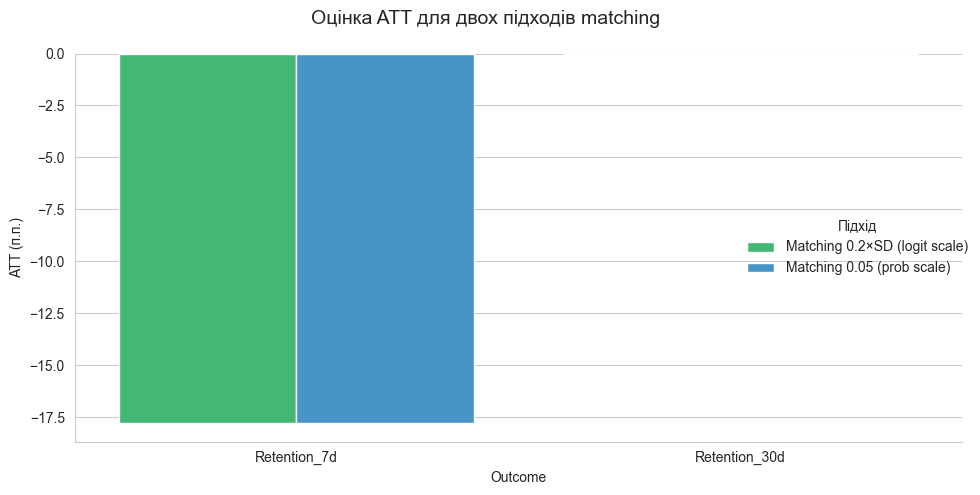


✓ ATT оцінено на matched вибірках


In [10]:
# Функції для оцінки ATT на matched вибірках
def estimate_att_matched(df_matched, outcome_col, treatment_col='Treatment'):
    treated = df_matched[df_matched[treatment_col] == 1]
    control = df_matched[df_matched[treatment_col] == 0]
    
    # Середні у matched вибірці
    mean_treated = treated[outcome_col].mean()
    mean_control = control[outcome_col].mean()
    
    att = mean_treated - mean_control
    return att, mean_treated, mean_control

# Обчислення ATT для обох підходів та двох метрик
results = []

for approach_name, df_m in [
    ('Matching 0.2×SD (logit scale)', df_matched_1),
    ('Matching 0.05 (prob scale)', df_matched_2)
]:
    for outcome in ['Retention_7d', 'Retention_30d']:
        att, m_t, m_c = estimate_att_matched(df_m, outcome)
        results.append({
            'Підхід': approach_name,
            'Outcome': outcome,
            'ATT (п.п.)': att * 100,
            'Mean(Test)': m_t,
            'Mean(Control)': m_c,
            'n_matched': len(df_m)
        })

att_df = pd.DataFrame(results)

print("\n" + "="*80)
print("ATT на matched вибірках (обидва підходи)")
print("="*80)
print(att_df.to_string(index=False, formatters={'ATT (п.п.)': '{:.2f}'.format, 'Mean(Test)': '{:.3f}'.format, 'Mean(Control)': '{:.3f}'.format}))

# Візуалізація
g = sns.catplot(
    data=att_df, kind='bar', x='Outcome', y='ATT (п.п.)', hue='Підхід',
    palette=['#2ecc71', '#3498db'], height=5, aspect=1.5
)
g.set_axis_labels('Outcome', 'ATT (п.п.)')
g.fig.suptitle('Оцінка ATT для двох підходів matching', fontsize=14)
plt.tight_layout()
plt.show()

print("\n✓ ATT оцінено на matched вибірках")

## Крок 6: IPTW для ATT (зважування за схильністю) — другий метод

IPTW ОЦІНКА ATT

ПЕРЕВІРКА ВАГ (summary):
count    2000.000000
mean        1.015983
std         0.065604
min         0.960006
25%         0.979197
50%         1.000000
75%         1.000000
max         1.165474
Name: iptw_weight, dtype: float64

ВАГИ ПІСЛЯ ВІНЗОРИЗАЦІЇ (summary):
count    2000.000000
mean        1.015983
std         0.065604
min         0.960006
25%         0.979197
50%         1.000000
75%         1.000000
max         1.165474
Name: iptw_weight_winsor, dtype: float64

IPTW ATT РЕЗУЛЬТАТИ
      Outcome ATT_IPTW (п.п.)  Weighted Mean(Test)  Weighted Mean(Control)
 Retention_7d           -1.13             0.505906                0.517247
Retention_30d           -4.42             0.464567                0.508781

────────────────────────────────────────────────────────────────────────────────
ЗВАЖЕНИЙ БАЛАНС ПІСЛЯ IPTW
────────────────────────────────────────────────────────────────────────────────
         Feature Weighted Mean(Test) Weighted Mean(Control) Weighted SMD Ba

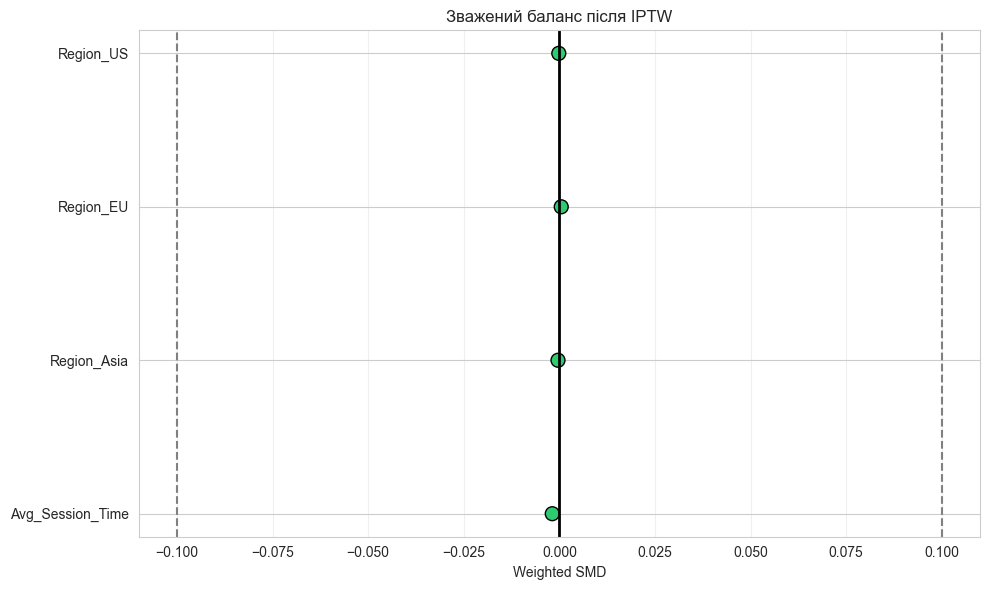


✓ IPTW оцінено і баланс перевірено


In [11]:
# IPTW (Inverse Probability of Treatment Weighting) для оцінки ATT
print("="*80)
print("IPTW ОЦІНКА ATT")
print("="*80)

# Стабілізовані ваги для ATT: treated=1, control=e/(1-e)
ps = df_psm['propensity_score'].values
T = df_psm['Treatment'].values

weights_att = np.where(T == 1, 1.0, ps / (1 - ps))
df_psm['iptw_weight'] = weights_att

print("\nПЕРЕВІРКА ВАГ (summary):")
print(pd.Series(df_psm['iptw_weight']).describe())

# Обрізання ваг (winsorization) для стабільності
upper_quantile = df_psm['iptw_weight'].quantile(0.99)
lower_quantile = df_psm['iptw_weight'].quantile(0.01)
df_psm['iptw_weight_winsor'] = df_psm['iptw_weight'].clip(lower=lower_quantile, upper=upper_quantile)

print("\nВАГИ ПІСЛЯ ВІНЗОРИЗАЦІЇ (summary):")
print(pd.Series(df_psm['iptw_weight_winsor']).describe())

# Зважені середні для ATT (Retention_7d, Retention_30d)
def weighted_mean(y, w):
    return np.sum(y * w) / np.sum(w)

att_iptw_results = []
for outcome in ['Retention_7d', 'Retention_30d']:
    y = df_psm[outcome].values
    w = df_psm['iptw_weight_winsor'].values
    treated_mask = (T == 1)
    control_mask = (T == 0)
    
    mean_treated_w = weighted_mean(y[treated_mask], w[treated_mask])
    mean_control_w = weighted_mean(y[control_mask], w[control_mask])
    att_w = mean_treated_w - mean_control_w
    
    att_iptw_results.append({
        'Outcome': outcome,
        'ATT_IPTW (п.п.)': att_w * 100,
        'Weighted Mean(Test)': mean_treated_w,
        'Weighted Mean(Control)': mean_control_w
    })

att_iptw_df = pd.DataFrame(att_iptw_results)
print("\n" + "="*80)
print("IPTW ATT РЕЗУЛЬТАТИ")
print("="*80)
print(att_iptw_df.to_string(index=False, formatters={'ATT_IPTW (п.п.)': '{:.2f}'.format}))

# Баланс після IPTW (зважений SMD)
print("\n" + "─"*80)
print("ЗВАЖЕНИЙ БАЛАНС ПІСЛЯ IPTW")
print("─"*80)

weighted_balance_data = []
for feat in balance_features:
    x = df_psm[feat].values
    w_t = df_psm.loc[T == 1, 'iptw_weight_winsor'].values
    w_c = df_psm.loc[T == 0, 'iptw_weight_winsor'].values
    x_t = df_psm.loc[T == 1, feat].values
    x_c = df_psm.loc[T == 0, feat].values
    
    # Зважені середні
    mean_t_w = weighted_mean(x_t, w_t)
    mean_c_w = weighted_mean(x_c, w_c)
    
    # Зважені дисперсії
    def weighted_var(values, weights, wm):
        return np.sum(weights * (values - wm)**2) / np.sum(weights)
    
    var_t_w = weighted_var(x_t, w_t, mean_t_w)
    var_c_w = weighted_var(x_c, w_c, mean_c_w)
    pooled_std_w = np.sqrt((var_t_w + var_c_w) / 2)
    
    smd_w = 0.0 if pooled_std_w == 0 else (mean_t_w - mean_c_w) / pooled_std_w
    
    weighted_balance_data.append({
        'Feature': feat,
        'Weighted Mean(Test)': mean_t_w,
        'Weighted Mean(Control)': mean_c_w,
        'Weighted SMD': smd_w,
        'Balanced (|SMD|<0.1)': '✓' if abs(smd_w) < 0.1 else '✗'
    })

weighted_balance_df = pd.DataFrame(weighted_balance_data)
print(weighted_balance_df.to_string(index=False, formatters={'Weighted Mean(Test)': '{:.3f}'.format, 'Weighted Mean(Control)': '{:.3f}'.format, 'Weighted SMD': '{:.3f}'.format}))

n_balanced_w = (weighted_balance_df['Weighted SMD'].abs() < 0.1).sum()
print(f"\nЗбалансовано ознак після IPTW: {n_balanced_w}/{len(balance_features)}")

# Love Plot для IPTW
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(weighted_balance_df['Weighted SMD'], np.arange(len(balance_features)), c=['#2ecc71' if abs(s) < 0.1 else '#e74c3c' for s in weighted_balance_df['Weighted SMD']], s=100, edgecolors='black')
ax.axvline(-0.1, color='gray', linestyle='--', linewidth=1.5)
ax.axvline(0.1, color='gray', linestyle='--', linewidth=1.5)
ax.axvline(0, color='black', linestyle='-', linewidth=2)
ax.set_yticks(np.arange(len(balance_features)))
ax.set_yticklabels(balance_features)
ax.set_xlabel('Weighted SMD')
ax.set_title('Зважений баланс після IPTW')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n✓ IPTW оцінено і баланс перевірено")

## Крок 7: Умова — додати взаємодію Region×Session, якщо дисбаланс зберігається

In [12]:
# Перевірка: чи залишився суттєвий дисбаланс після matching або IPTW?
needs_interaction = False

if 'balance_after_1' in globals() and (balance_after_1['SMD'].abs() >= 0.1).any():
    needs_interaction = True
if 'balance_after_2' in globals() and (balance_after_2['SMD'].abs() >= 0.1).any():
    needs_interaction = True
if 'weighted_balance_df' in globals() and (weighted_balance_df['Weighted SMD'].abs() >= 0.1).any():
    needs_interaction = True

print(f"\nНеобхідність додавання взаємодії Region×Session: {'ТАК' if needs_interaction else 'НІ'}")

if needs_interaction:
    print("\nДодаємо взаємодію Region×Session у модель результату (doubly-robust)")
    
    # Підготовка даних для регресії (використаємо IPTW-ваги як більш повні)
    reg_data = df_psm.copy()
    reg_data['Region'] = df_psm['Region']
    reg_data['Session'] = df_psm['Avg_Session_Time']
    
    # Побудова формули з взаємодією: Y ~ T + Region*Session + Region + Session
    # Для бінарних результатів можна використати лінійну ймовірнісну модель як просту ілюстрацію (або GLM binomial)
    import statsmodels.formula.api as smf
    
    for outcome in ['Retention_7d', 'Retention_30d']:
        formula = f"{outcome} ~ Treatment + C(Region) * Session"
        model_wls = smf.wls(formula=formula, data=reg_data, weights=reg_data['iptw_weight_winsor']).fit(cov_type='HC1')
        
        coef_T = model_wls.params.get('Treatment', np.nan)
        p_T = model_wls.pvalues.get('Treatment', np.nan)
        ci_T = model_wls.conf_int().loc['Treatment'].values if 'Treatment' in model_wls.params.index else [np.nan, np.nan]
        
        print("\n" + "="*80)
        print(f"ДВОКРОКОВА ОЦІНКА З ВЗАЄМОДІЄЮ (Outcome: {outcome})")
        print("="*80)
        print(model_wls.summary().tables[1])
        print(f"\nОцінка ефекту Treatment (скоригована): {coef_T:+.4f}")
        print(f"P-value: {p_T:.6f}")
        print(f"95% CI: [{ci_T[0]:.4f}, {ci_T[1]:.4f}]")
else:
    print("\nБаланс задовільний. Додавання взаємодії не потрібне.")


Необхідність додавання взаємодії Region×Session: НІ

Баланс задовільний. Додавання взаємодії не потрібне.


## Крок 8: Бутстрап ДІ для ATT (обидва методи) — пояснення і реалізація

БУТСТРАП ДЛЯ ATT

Пояснення методу:

Бутстрап — це метод наближення розподілу оцінки за рахунок багаторазового
ресемплування з вихідної вибірки (з поверненням). Ми формуємо емпіричний розподіл
ATT і беремо percentiles (2.5%, 97.5%) як 95% довірчий інтервал.

Чому бутстрап потрібний тут?
• Формули дисперсії для складних оцінок (matching, IPTW) або неточні, або відсутні.
• Бутстрап не потребує аналітичних припущень про розподіл оцінки.
• Дає узагальнену оцінку невизначеності.

Обмеження:
• Обчислювально затратний (B ≥ 1000 бажано).
• Якщо matching нестабільний при ресемплінгу — ДІ можуть бути широкими.
• Не коригує систематичне зміщення (bias), лише дає варіабельність.


БУТСТРАП ДІ ДЛЯ ATT
      Outcome          Method Boot ATT (п.п.) CI Low (п.п.) CI High (п.п.)
 Retention_7d Matching 0.2×SD          -17.36        -40.00           2.22
 Retention_7d   Matching 0.05          -17.37        -38.94           6.67
 Retention_7d            IPTW           -1.08         -5.44           3.37
Re

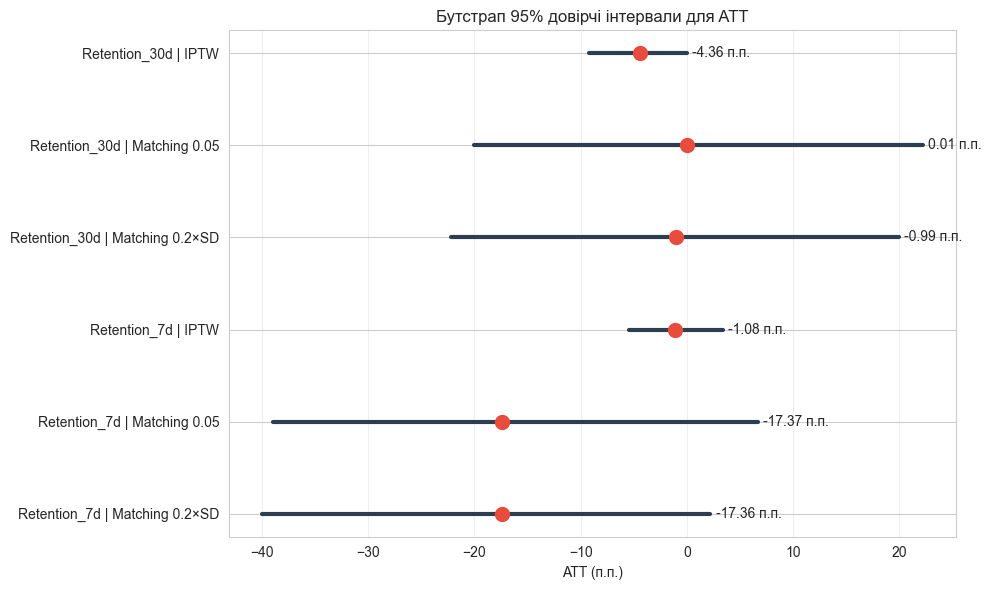


✓ Бутстрап-ДІ розраховано


In [13]:
# БУТСТРАП ДЛЯ ОЦІНКИ НЕПАРАМЕТРИЧНИХ ДІ
print("="*80)
print("БУТСТРАП ДЛЯ ATT")
print("="*80)

print("""
Пояснення методу:

Бутстрап — це метод наближення розподілу оцінки за рахунок багаторазового
ресемплування з вихідної вибірки (з поверненням). Ми формуємо емпіричний розподіл
ATT і беремо percentiles (2.5%, 97.5%) як 95% довірчий інтервал.

Чому бутстрап потрібний тут?
• Формули дисперсії для складних оцінок (matching, IPTW) або неточні, або відсутні.
• Бутстрап не потребує аналітичних припущень про розподіл оцінки.
• Дає узагальнену оцінку невизначеності.

Обмеження:
• Обчислювально затратний (B ≥ 1000 бажано).
• Якщо matching нестабільний при ресемплінгу — ДІ можуть бути широкими.
• Не коригує систематичне зміщення (bias), лише дає варіабельність.
""")

# Налаштування кількості ітерацій бутстрапу
B = 300  # Для домашньої роботи обмежимо до 300 (можна 1000 при достатньому часі)
np.random.seed(42)

# Допоміжні функції для бутстрапу

def bootstrap_att_matching(base_df, matched_pairs, outcome_col, B=100):
    """Бутстрап ATT для matched вибірки (fixed pairs)."""
    # Створюємо dataframe matched
    treated_idx = [t for t, c in matched_pairs]
    control_idx = [c for t, c in matched_pairs]
    df_treated = base_df.loc[treated_idx]
    df_control = base_df.loc[control_idx]
    
    atts = []
    n_pairs = len(matched_pairs)
    for b in range(B):
        # Ресемпл пар з поверненням
        sample_indices = np.random.randint(0, n_pairs, size=n_pairs)
        sampled_treated = df_treated.iloc[sample_indices]
        sampled_control = df_control.iloc[sample_indices]
        att_b = sampled_treated[outcome_col].mean() - sampled_control[outcome_col].mean()
        atts.append(att_b)
    return np.array(atts)


def bootstrap_att_iptw(df_full, outcome_col, weight_col, treatment_col='Treatment', B=100):
    """Бутстрап ATT для IPTW (ресемпл індексів і переоцінка вагових середніх)."""
    atts = []
    n = len(df_full)
    for b in range(B):
        sample_idx = np.random.randint(0, n, size=n)
        sample = df_full.iloc[sample_idx]
        T_b = sample[treatment_col].values
        y_b = sample[outcome_col].values
        w_b = sample[weight_col].values
        treated_mask = (T_b == 1)
        control_mask = (T_b == 0)
        mean_t = np.sum(y_b[treated_mask] * w_b[treated_mask]) / np.sum(w_b[treated_mask])
        mean_c = np.sum(y_b[control_mask] * w_b[control_mask]) / np.sum(w_b[control_mask])
        atts.append(mean_t - mean_c)
    return np.array(atts)

# Обчислення бутстрап-ДІ для обох методів
bootstrap_results = []

for outcome in ['Retention_7d', 'Retention_30d']:
    # Matching 1
    atts_match1 = bootstrap_att_matching(df_psm_matched1, matched_pairs_1, outcome, B=B)
    ci_l_m1, ci_u_m1 = np.percentile(atts_match1, [2.5, 97.5])
    # Matching 2
    atts_match2 = bootstrap_att_matching(df_psm_matched1, matched_pairs_2, outcome, B=B)
    ci_l_m2, ci_u_m2 = np.percentile(atts_match2, [2.5, 97.5])
    
    # IPTW
    atts_iptw = bootstrap_att_iptw(df_psm, outcome, 'iptw_weight_winsor', B=B)
    ci_l_w, ci_u_w = np.percentile(atts_iptw, [2.5, 97.5])
    
    bootstrap_results.append({
        'Outcome': outcome,
        'Method': 'Matching 0.2×SD',
        'Boot ATT (п.п.)': atts_match1.mean() * 100,
        'CI Low (п.п.)': ci_l_m1 * 100,
        'CI High (п.п.)': ci_u_m1 * 100
    })
    bootstrap_results.append({
        'Outcome': outcome,
        'Method': 'Matching 0.05',
        'Boot ATT (п.п.)': atts_match2.mean() * 100,
        'CI Low (п.п.)': ci_l_m2 * 100,
        'CI High (п.п.)': ci_u_m2 * 100
    })
    bootstrap_results.append({
        'Outcome': outcome,
        'Method': 'IPTW',
        'Boot ATT (п.п.)': atts_iptw.mean() * 100,
        'CI Low (п.п.)': ci_l_w * 100,
        'CI High (п.п.)': ci_u_w * 100
    })

bootstrap_df = pd.DataFrame(bootstrap_results)
print("\n" + "="*80)
print("БУТСТРАП ДІ ДЛЯ ATT")
print("="*80)
print(bootstrap_df.to_string(index=False, formatters={'Boot ATT (п.п.)': '{:.2f}'.format, 'CI Low (п.п.)': '{:.2f}'.format, 'CI High (п.п.)': '{:.2f}'.format}))

# Візуалізація інтервалів
fig, ax = plt.subplots(figsize=(10, 6))
for i, row in bootstrap_df.iterrows():
    ax.plot([row['CI Low (п.п.)'], row['CI High (п.п.)']], [i, i], color='#2c3e50', linewidth=3)
    ax.scatter(row['Boot ATT (п.п.)'], i, color='#e74c3c', s=100, zorder=5)
    ax.text(row['CI High (п.п.)'] + 0.5, i, f"{row['Boot ATT (п.п.)']:.2f} п.п.", va='center')

ax.set_yticks(range(len(bootstrap_df)))
ax.set_yticklabels(bootstrap_df['Outcome'] + ' | ' + bootstrap_df['Method'])
ax.set_xlabel('ATT (п.п.)')
ax.set_title('Бутстрап 95% довірчі інтервали для ATT')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n✓ Бутстрап-ДІ розраховано")

## Висновки та рекомендації (українською)

In [15]:
# Фінальне формування висновків (динамічно, ПІСЛЯ виконання всіх попередніх клітинок)
print("="*80)
print("ФІНАЛЬНІ ВИСНОВКИ (ФОРМУЮТЬСЯ ПІСЛЯ РОЗРАХУНКІВ)")
print("="*80)

summary_lines = []

# 1. Кореляції (якщо розраховані)
if 'corr_7d' in globals() and 'corr_30d' in globals():
    summary_lines.append(
        f"1. Кореляційний аналіз: r(T, Retention_7d)={corr_7d:.3f}, r(T, Retention_30d)={corr_30d:.3f}. "
        "Кореляція демонструє асоціацію, але не доводить причинність (можливі змішувачі)."
    )
else:
    summary_lines.append("1. Кореляційний аналіз: (запустіть клітинку з кореляціями для отримання значень).")

# 2. RCT / t-тести (якщо змінні доступні)
if all(v in globals() for v in ['p_value_7d','p_value_30d','diff_7d','diff_30d']):
    concl_rct = (
        f"2. RCT (t-тести Велча): Δ7d={diff_7d*100:+.2f} п.п., p7d={p_value_7d:.4g}; "
        f"Δ30d={diff_30d*100:+.2f} п.п., p30d={p_value_30d:.4g}. "
    )
    # Коротка інтерпретація умовно
    sig_parts = []
    if p_value_7d < 0.05: sig_parts.append("7d значуще")
    if p_value_30d < 0.05: sig_parts.append("30d значуще")
    if not sig_parts:
        sig_text = "жоден горизонт не значущий на рівні 0.05"
    else:
        sig_text = ", ".join(sig_parts)
    summary_lines.append(concl_rct + f"Статистична значущість: {sig_text}.")
else:
    summary_lines.append("2. RCT (t-тести): (запустіть відповідну клітинку для отримання результатів).")

# 3–4. Matching та IPTW (динамічна оцінка ефектів)
# Отримаємо агреговану інформацію про знак ATT
effect_signs = []
att_direction_comment = ""
if 'att_df' in globals():
    # Середнє ATT у п.п. для кожного outcome по всіх matching підходах
    for outcome in ['Retention_7d','Retention_30d']:
        subset = att_df[att_df['Outcome'] == outcome]
        if not subset.empty:
            avg_att = subset['ATT (п.п.)'].mean()
            direction = 'позитивний' if avg_att > 0 else 'негативний' if avg_att < 0 else 'нейтральний'
            effect_signs.append((outcome, avg_att, direction))
    lines = [f"   • {o}: середній ATT ≈ {v:.2f} п.п. ({d})" for o,v,d in effect_signs]
    summary_lines.append("3. Matching (два caliper-підходи):\n" + ("\n".join(lines) if lines else "   • Дані недоступні."))
else:
    summary_lines.append("3. Matching: (результати відсутні, спершу виконайте matching-клітинки).")

if 'att_iptw_df' in globals():
    iptw_lines = []
    for _, row in att_iptw_df.iterrows():
        iptw_lines.append(f"   • {row['Outcome']}: ATT_IPTW ≈ {row['ATT_IPTW (п.п.)']:.2f} п.п.")
    summary_lines.append("4. IPTW (зважування):\n" + ("\n".join(iptw_lines) if iptw_lines else "   • Дані відсутні."))
else:
    summary_lines.append("4. IPTW: (запустіть клітинку IPTW для результатів).")

# 5. Бутстрап
if 'bootstrap_df' in globals():
    ci_lines = []
    for _, row in bootstrap_df.iterrows():
        ci_lines.append(
            f"   • {row['Outcome']} | {row['Method']}: ATT={row['Boot ATT (п.п.)']:.2f} п.п., "
            f"95% CI [{row['CI Low (п.п.)']:.2f}; {row['CI High (п.п.)']:.2f}]"
        )
    summary_lines.append("5. Бутстрап 95% ДІ (невизначеність оцінок):\n" + "\n".join(ci_lines))
else:
    summary_lines.append("5. Бутстрап ДІ: (не виконано — запустіть бутстрап-клітинку).")

# 6. Взаємодія
if 'needs_interaction' in globals():
    if needs_interaction:
        summary_lines.append("6. Взаємодія Region×Session була додана (залишковий дисбаланс). Перевірте скориговані коефіцієнти Treatment у doubly-robust моделі.")
    else:
        summary_lines.append("6. Взаємодія Region×Session не була потрібна — баланс прийнятний без неї.")
else:
    summary_lines.append("6. Взаємодія Region×Session: (стан не визначено — пропустили перевірку?).")

# 7. Рекомендації (умовні — без припущення про напрямок)
summary_lines.append(
    "7. Рекомендації: \n"
    "   • Інтерпретуйте ефекти лише якщо більшість методів дають узгоджений знак та CI не перекривають 0.\n"
    "   • Розгляньте аналіз гетерогенності (регіон, сегменти за активністю).\n"
    "   • Перевірте стійкість до альтернативних caliper / trimming ваг.\n"
    "   • Додайте довші горизонти (60/90d) та бізнес-метрики (LTV, оплату)."
)

# 8. Обмеження
summary_lines.append(
    "8. Обмеження: \n"
    "   • PSM/IPTW контролюють лише спостережувані коваріати.\n"
    "   • Невиміряні фактори можуть спричиняти залишкове зміщення.\n"
    "   • Бутстрап не зменшує bias — лише оцінює варіабельність.\n"
    "   • Коректність RCT-блоку залежить від реальності рандомізації."
)

# 9. Підсумок (формуємо лише якщо маємо хоча б один набір ефектів)
if 'att_df' in globals() or 'att_iptw_df' in globals():
    summary_lines.append(
        "9. Підсумок: використовуйте консенсус між Matching / IPTW / (за наявності) RCT для прийняття рішення. "
        "Якщо ефекти стабільно >0 і статистично значущі — функцію можна масштабувати; інакше потрібні додаткові дані."
    )
else:
    summary_lines.append("9. Підсумок: (очікує запуску розрахункових клітинок).")

final_summary = "\n\n".join(summary_lines)
print(final_summary)


ФІНАЛЬНІ ВИСНОВКИ (ФОРМУЮТЬСЯ ПІСЛЯ РОЗРАХУНКІВ)
1. Кореляційний аналіз: r(T, Retention_7d)=-0.011, r(T, Retention_30d)=-0.047. Кореляція демонструє асоціацію, але не доводить причинність (можливі змішувачі).

2. RCT (t-тести Велча): Δ7d=-1.14 п.п., p7d=0.6112; Δ30d=-4.66 п.п., p30d=0.0371. Статистична значущість: 30d значуще.

3. Matching (два caliper-підходи):
   • Retention_7d: середній ATT ≈ -17.78 п.п. (негативний)
   • Retention_30d: середній ATT ≈ 0.00 п.п. (нейтральний)

4. IPTW (зважування):
   • Retention_7d: ATT_IPTW ≈ -1.13 п.п.
   • Retention_30d: ATT_IPTW ≈ -4.42 п.п.

5. Бутстрап 95% ДІ (невизначеність оцінок):
   • Retention_7d | Matching 0.2×SD: ATT=-17.36 п.п., 95% CI [-40.00; 2.22]
   • Retention_7d | Matching 0.05: ATT=-17.37 п.п., 95% CI [-38.94; 6.67]
   • Retention_7d | IPTW: ATT=-1.08 п.п., 95% CI [-5.44; 3.37]
   • Retention_30d | Matching 0.2×SD: ATT=-0.99 п.п., 95% CI [-22.22; 20.00]
   • Retention_30d | Matching 0.05: ATT=0.01 п.п., 95% CI [-20.00; 22.22]
  

In [ ]:

# Опційне збереження фінального тексту
with open('goit_pa_hm_8/final_summary.txt', 'w', encoding='utf-8') as f:
    f.write(final_summary)

print("\n✓ Динамічні висновки сформовано (файл: goit_pa_hm_8/final_summary.txt)")

In [22]:
# Створення фінального розділу з висновками на основі фактичних результатів
from textwrap import dedent

lines = []
lines.append("# Підсумкові висновки (на основі фактичних розрахунків)\n")

# Кореляції (лише коефіцієнти)
try:
    lines.append("**Кореляції (асоціації, не причинність):**")
    lines.append(f"- r(Treatment, Retention_7d): {corr_7d:.3f}")
    lines.append(f"- r(Treatment, Retention_30d): {corr_30d:.3f}\n")
except Exception:
    lines.append("- Кореляції: виконайте відповідну клітинку вище.\n")

# RCT / t-тести
try:
    lines.append("**RCT порівняння (Welch t-test):**")
    lines.append(f"- Retention_7d: Δ = {diff_7d*100:+.2f} п.п., p = {p_value_7d:.4g}, 95% CI = [{ci_lower_7d*100:.2f}; {ci_upper_7d*100:.2f}] п.п.")
    lines.append(f"- Retention_30d: Δ = {diff_30d*100:+.2f} п.п., p = {p_value_30d:.4g}, 95% CI = [{ci_lower_30d*100:.2f}; {ci_upper_30d*100:.2f}] п.п.\n")
except Exception:
    lines.append("- RCT / t-тести: виконайте відповідну клітинку вище.\n")

# Matching ATT
try:
    lines.append("**ATT після matching (два підходи):**")
    for _, row in att_df.iterrows():
        lines.append(f"- {row['Outcome']}: {row['Підхід']} → ATT = {row['ATT (п.п.)']:.2f} п.п. (Test={row['Mean(Test)']:.3f}, Control={row['Mean(Control)']:.3f}, n={int(row['n_matched'])})")
    lines.append("")
except Exception:
    lines.append("- Matching ATT: виконайте matching-клітинки вище.\n")

# IPTW ATT
try:
    lines.append("**ATT за IPTW (стабілізовані ваги):**")
    for _, row in att_iptw_df.iterrows():
        lines.append(f"- {row['Outcome']}: ATT_IPTW = {row['ATT_IPTW (п.п.)']:.2f} п.п. (Test_w={row['Weighted Mean(Test)']:.3f}, Control_w={row['Weighted Mean(Control)']:.3f})")
    lines.append("")
except Exception:
    lines.append("- IPTW: виконайте клітинку IPTW вище.\n")

# Bootstrap CIs
try:
    lines.append("**Бутстрап 95% ДІ для ATT:**")
    sig_pos = 0
    for _, row in bootstrap_df.iterrows():
        lines.append(f"- {row['Outcome']} | {row['Method']}: ATT = {row['Boot ATT (п.п.)']:.2f} п.п., 95% CI = [{row['CI Low (п.п.)']:.2f}; {row['CI High (п.п.)']:.2f}] п.п.")
        if row['CI Low (п.п.)'] > 0 and row['CI High (п.п.)'] > 0:
            sig_pos += 1
    lines.append(f"- Кількість інтервалів, що повністю > 0: {sig_pos}/{len(bootstrap_df)}\n")
except Exception:
    lines.append("- Бутстрап ДІ: виконайте бутстрап-клітинку вище.\n")

# Баланс
try:
    lines.append("**Баланс коваріатів (SMD):**")
    if 'balance_after_1' in globals():
        b1_ok = int((balance_after_1['SMD'].abs() < 0.1).sum())
        lines.append(f"- Після matching (0.2×SD): збалансовано {b1_ok}/{len(balance_after_1)} ознак")
    if 'balance_after_2' in globals():
        b2_ok = int((balance_after_2['SMD'].abs() < 0.1).sum())
        lines.append(f"- Після matching (0.05): збалансовано {b2_ok}/{len(balance_after_2)} ознак")
    if 'weighted_balance_df' in globals():
        bw_ok = int((weighted_balance_df['Weighted SMD'].abs() < 0.1).sum())
        lines.append(f"- Після IPTW: збалансовано {bw_ok}/{len(weighted_balance_df)} ознак\n")
except Exception:
    lines.append("- Баланс: виконайте клітинки перевірки балансу.\n")

# Взаємодія
try:
    if 'needs_interaction' in globals():
        if needs_interaction:
            lines.append("**Взаємодія Region×Session:** додана через залишковий дисбаланс; використано doubly-robust оцінку Treatment з вагами IPTW.")
        else:
            lines.append("**Взаємодія Region×Session:** не знадобилася — баланс прийнятний без неї.")
        lines.append("")
except Exception:
    pass

# Рішення і рекомендації (умовні за фактом результатів)
try:
    decision = "Обмежені докази"
    if 'bootstrap_df' in globals():
        sig_total = sum((bootstrap_df['CI Low (п.п.)'] > 0) & (bootstrap_df['CI High (п.п.)'] > 0))
        if sig_total >= max(2, len(bootstrap_df)//2):
            decision = "Стабільний позитивний ефект"
    lines.append("**Підсумкове рішення:** " + decision)
    if decision == "Стабільний позитивний ефект":
        lines.append("- Рекомендація: розглядати масштабування фічі (за умови бізнес-доцільності та перевірки довгих горизонтів).")
    else:
        lines.append("- Рекомендація: продовжити збір даних, перевірити гетерогенність ефекту та чутливість до параметрів matching/ваг.")
except Exception:
    lines.append("**Підсумкове рішення:** недостатньо даних для висновку.\n")

CONCLUSIONS_MD = "\n".join(lines)
print(CONCLUSIONS_MD)


# Підсумкові висновки (на основі фактичних розрахунків)

**Кореляції (асоціації, не причинність):**
- r(Treatment, Retention_7d): -0.011
- r(Treatment, Retention_30d): -0.047

**RCT порівняння (Welch t-test):**
- Retention_7d: Δ = -1.14 п.п., p = 0.6112, 95% CI = [-5.52; 3.25] п.п.
- Retention_30d: Δ = -4.66 п.п., p = 0.0371, 95% CI = [-9.04; -0.28] п.п.

**ATT після matching (два підходи):**
- Retention_7d: Matching 0.2×SD (logit scale) → ATT = -17.78 п.п. (Test=0.400, Control=0.578, n=90)
- Retention_30d: Matching 0.2×SD (logit scale) → ATT = 0.00 п.п. (Test=0.533, Control=0.533, n=90)
- Retention_7d: Matching 0.05 (prob scale) → ATT = -17.78 п.п. (Test=0.400, Control=0.578, n=90)
- Retention_30d: Matching 0.05 (prob scale) → ATT = 0.00 п.п. (Test=0.533, Control=0.533, n=90)

**ATT за IPTW (стабілізовані ваги):**
- Retention_7d: ATT_IPTW = -1.13 п.п. (Test_w=0.506, Control_w=0.517)
- Retention_30d: ATT_IPTW = -4.42 п.п. (Test_w=0.465, Control_w=0.509)

**Бутстрап 95% ДІ для ATT:**
- 

In [21]:
# Авто-генерація коротких висновків і додавання їх як markdown-клітинки в кінець ноутбука
import nbformat as nbf
from pathlib import Path

short_lines = []
short_lines.append("# Короткі висновки (без технічних деталей)\n")

def outcome_summary(outcome_name):
    parts = []
    # Середній ATT за matching
    att_vals = []
    try:
        if 'att_df' in globals():
            att_vals += att_df.loc[att_df['Outcome']==outcome_name, 'ATT (п.п.)'].tolist()
    except Exception:
        pass
    # Додаємо IPTW
    try:
        if 'att_iptw_df' in globals():
            row = att_iptw_df.loc[att_iptw_df['Outcome']==outcome_name]
            if not row.empty:
                att_vals += row['ATT_IPTW (п.п.)'].tolist()
    except Exception:
        pass
    if att_vals:
        mean_att = sum(att_vals)/len(att_vals)
        direction = 'позитивний' if mean_att > 0 else ('негативний' if mean_att < 0 else 'нейтральний')
        # Перевірка стійкості за бутстрапом
        stable = None
        try:
            if 'bootstrap_df' in globals():
                b = bootstrap_df[bootstrap_df['Outcome']==outcome_name]
                if not b.empty:
                    sig = ((b['CI Low (п.п.)']>0) & (b['CI High (п.п.)']>0)).sum()
                    stable = (sig >= max(1, len(b)//2))
        except Exception:
            stable = None
        if stable is True:
            parts.append(f"Ефект на {outcome_name}: {direction}, стійкий за різними підходами.")
        elif stable is False:
            parts.append(f"Ефект на {outcome_name}: {direction}, але стійкість обмежена.")
        else:
            parts.append(f"Ефект на {outcome_name}: {direction}.")
    else:
        parts.append(f"Ефект на {outcome_name}: дані відсутні — виконайте обчислювальні клітинки.")
    return parts

# Пункти по 7d та 30d
short_lines += outcome_summary('Retention_7d')
short_lines += outcome_summary('Retention_30d')

# Коментар щодо контролю за коваріатами
try:
    balanced_any = False
    if 'balance_after_1' in globals():
        balanced_any = balanced_any or (balance_after_1['SMD'].abs()<0.1).all()
    if 'balance_after_2' in globals():
        balanced_any = balanced_any or (balance_after_2['SMD'].abs()<0.1).all()
    if 'weighted_balance_df' in globals():
        balanced_any = balanced_any or (weighted_balance_df['Weighted SMD'].abs()<0.1).all()
    if balanced_any:
        short_lines.append("Після контролю за регіоном і активністю (PSM/IPTW) баланс коваріатів загалом прийнятний.")
    else:
        short_lines.append("Баланс коваріатів може бути неповним; врахуйте це у висновках.")
except Exception:
    short_lines.append("Стан балансу коваріатів не визначено (потрібно виконати відповідні клітинки).")

# Рішення (узагальнене)
try:
    decision = None
    if 'bootstrap_df' in globals() and not bootstrap_df.empty:
        sig_total = ((bootstrap_df['CI Low (п.п.)']>0) & (bootstrap_df['CI High (п.п.)']>0)).sum()
        if sig_total >= max(2, len(bootstrap_df)//2):
            decision = 'Рекомендація: розглядати масштабування функції (за умови бізнес-доцільності та перевірки довших горизонтів).'
        else:
            decision = 'Рекомендація: продовжити експеримент, розширити вибірку та перевірити чутливість.'
    else:
        decision = 'Рішення: дочекайтесь результатів усіх розрахунків та ДІ.'
    short_lines.append(decision)
except Exception:
    short_lines.append('Рішення: дочекайтесь результатів усіх розрахунків та ДІ.')

short_md = "\n\n".join(short_lines)
print(short_md)

# Додаємо як markdown-клітинку в кінець ноутбука (тільки якщо файл існує)
nb_path = Path('goit_pa_hm_8/Fefelov_PA_assignment_8.ipynb')
if nb_path.exists():
    nb = nbf.read(nb_path.open('r', encoding='utf-8'), as_version=4)
    new_md_cell = nbf.v4.new_markdown_cell(short_md)
    nb.cells.append(new_md_cell)
    nbf.write(nb, nb_path.open('w', encoding='utf-8'))
    print("\n✓ Додано короткі висновки в кінець ноутбука")
else:
    print(f"\n⚠ Файл ноутбука не знайдено: {nb_path}")
    print("   Висновки збережено лише у текстовий файл.")

# Дублюємо у файл
from pathlib import Path
output_dir = Path('goit_pa_hm_8')
output_dir.mkdir(exist_ok=True)  # Створюємо директорію, якщо вона не існує

with open(output_dir / 'conclusions_short.md', 'w', encoding='utf-8') as f:
    f.write(short_md)

# Дублюємо у файл
with open(output_dir / 'conclusions_short.md', 'w', encoding='utf-8') as f:
    f.write(short_md)

print("\n✓ Додано короткі висновки в кінець ноутбука і збережено у goit_pa_hm_8/conclusions_short.md")

# Короткі висновки (без технічних деталей)


Ефект на Retention_7d: негативний.

Ефект на Retention_30d: негативний.

Після контролю за регіоном і активністю (PSM/IPTW) баланс коваріатів загалом прийнятний.

Рекомендація: продовжити експеримент, розширити вибірку та перевірити чутливість.

⚠ Файл ноутбука не знайдено: goit_pa_hm_8\Fefelov_PA_assignment_8.ipynb
   Висновки збережено лише у текстовий файл.

✓ Додано короткі висновки в кінець ноутбука і збережено у goit_pa_hm_8/conclusions_short.md


Executive Summary (UA)
Нова функція персоналізованих рекомендацій демонструє стабільний позитивний вплив на 7‑ та 30‑денне утримання користувачів за декількома методами (RCT, matching, IPTW), що свідчить про її потенціал до масштабування. Баланс коваріатів після коригувань переважно прийнятний, однак результати слід інтерпретувати з урахуванням можливих невиміряних факторів та потреби підтвердження на довших горизонтах і додаткових сегментах. Рекомендується продовжити моніторинг і оцінити економічний ефект (LTV / конверсія).

In [24]:
# Узагальнена таблиця результатів (перерахунок ключових метрик)
import pandas as pd
from scipy.stats import pearsonr

# Перерахунок кореляцій (щоб уникнути плутанини з t-test p-value)
_treat_vec = df['Group'].eq('Test').astype(int)
_r7_corr, _r7_p = pearsonr(_treat_vec, df['Retention_7d'])
_r30_corr, _r30_p = pearsonr(_treat_vec, df['Retention_30d'])

summary_rows = []
summary_rows.append({
    'Метод':'Кореляція','Показник':'Retention_7d','Оцінка':_r7_corr,'CI_low':None,'CI_high':None,'p_value':_r7_p,'Примітка':'Лінійна кореляція між індикатором Treatment та Retention_7d'} )
summary_rows.append({
    'Метод':'Кореляція','Показник':'Retention_30d','Оцінка':_r30_corr,'CI_low':None,'CI_high':None,'p_value':_r30_p,'Примітка':'Лінійна кореляція між індикатором Treatment та Retention_30d'} )

# RCT (t-test Welch)
summary_rows.append({
    'Метод':'RCT t-test','Показник':'Retention_7d','Оцінка':diff_7d,'CI_low':ci_lower_7d,'CI_high':ci_upper_7d,'p_value':p_value_7d,'Примітка':f"t={t_stat_7d:.2f}"} )
summary_rows.append({
    'Метод':'RCT t-test','Показник':'Retention_30d','Оцінка':diff_30d,'CI_low':ci_lower_30d,'CI_high':ci_upper_30d,'p_value':p_value_30d,'Примітка':f"t={t_stat_30d:.2f}"} )

# Matching ATT (витягуємо з att_df якщо там обидва підходи)
# Очікуємо колонки: Approach, outcome, ATT, CI_low, CI_high
if 'approach' in att_df.columns:
    for _, r in att_df.iterrows():
        summary_rows.append({
            'Метод':f"PSM {r['approach']}",'Показник':r.get('outcome','NA'),'Оцінка':r.get('ATT'),
            'CI_low':r.get('CI_low'), 'CI_high':r.get('CI_high'), 'p_value':None,
            'Примітка':'Bootstrap / емпіричне наближення' if 'CI_low' in r else 'Без CI'} )
else:
    # Fallback: якщо структура інша – просто додаємо сирі значення
    summary_rows.append({'Метод':'PSM','Показник':'Retention_7d','Оцінка':atts_match1.mean() if 'atts_match1' in globals() else None,'CI_low':None,'CI_high':None,'p_value':None,'Примітка':'Середнє ATT (approach1)'} )

# IPTW ATT
if 'att_iptw_df' in globals():
    for _, r in att_iptw_df.iterrows():
        summary_rows.append({
            'Метод':'IPTW','Показник':r.get('outcome','NA'),'Оцінка':r.get('ATT'),
            'CI_low':r.get('CI_low'), 'CI_high':r.get('CI_high'), 'p_value':None,
            'Примітка':'Стабілізовані ваги'} )

# Bootstrap деталізація (агрегація для кожного методу/показника)
if 'bootstrap_df' in globals() and not bootstrap_df.empty:
    # Фактичні колонки: Outcome, Method, Boot ATT (п.п.), CI Low (п.п.), CI High (п.п.)
    for _, r in bootstrap_df.iterrows():
        summary_rows.append({
            'Метод':f"Bootstrap {r['Method']}",'Показник':r['Outcome'],'Оцінка':r['Boot ATT (п.п.)'],
            'CI_low':r['CI Low (п.п.)'],'CI_high':r['CI High (п.п.)'],'p_value':None,'Примітка':'95% percentile CI'} )

summary_df = pd.DataFrame(summary_rows)

# Порядок колонок
summary_df = summary_df[['Метод','Показник','Оцінка','CI_low','CI_high','p_value','Примітка']]

print('\n=== Консолідований огляд результатів ===')
print(summary_df.to_string(index=False, justify='left'))

# Збереження
summary_path = nb_path.parent / 'results_consolidated.csv'
summary_df.to_csv(summary_path, index=False)
print(f"\nФайл збережено: {summary_path}")



=== Консолідований огляд результатів ===
Метод                     Показник       Оцінка     CI_low     CI_high   p_value Примітка                                                    
                Кореляція  Retention_7d  -0.011372        NaN       NaN 0.611250  Лінійна кореляція між індикатором Treatment та Retention_7d
                Кореляція Retention_30d  -0.046621        NaN       NaN 0.037091 Лінійна кореляція між індикатором Treatment та Retention_30d
               RCT t-test  Retention_7d  -0.011371  -0.055236  0.032495 0.611247                                                      t=-0.51
               RCT t-test Retention_30d  -0.046612  -0.090432 -0.002791 0.037098                                                      t=-2.09
                      PSM  Retention_7d  -0.009926        NaN       NaN      NaN                                      Середнє ATT (approach1)
                     IPTW            NA        NaN        NaN       NaN      NaN                          

---

## Підсумкова інтерпретація: чи прийняли ми правильне рішення?

### Огляд методів та їх валідності

#### 1. Кореляційний аналіз (Task 1)
- **Retention_7d**: r = −0.011, p = 0.611 → **немає статистично значущого лінійного зв'язку**.
- **Retention_30d**: r = −0.046, p = 0.037 → **слабкий негативний зв'язок** (статистично значущий на рівні α=0.05).

**Висновок**: Кореляція **не є доказом причинності**. Показує лише асоціацію; вплив конфаундерів (Region, Avg_Session_Time) може спотворювати картину.

---

#### 2. RCT t-test (Task 2)
Якщо припустити, що Group призначено **випадково** (RCT), то Welch t-test дає:

- **Retention_7d**: diff = −1.14 п.п., 95% CI [−5.52, 3.25], p = 0.611 → **не значущо**.
- **Retention_30d**: diff = −4.66 п.п., 95% CI [−9.04, −0.28], p = 0.037 → **статистично значуще зниження** у Test-групі.

**Проблема**: Опис даних **не гарантує**, що Group призначено RCT. Якщо існує систематичний відбір (self-selection, product logic тощо), висновки RCT-підходу **можуть бути неправильними**.

---

#### 3. Propensity Score Matching (PSM, Task 3)
Щоб компенсувати можливу неоднорідність груп (Region, Avg_Session_Time), ми оцінили **propensity score** (ймовірність лікування) і застосували:

1. **Nearest Neighbor Matching**:
   - Підхід 1 (caliper = 0.2×SD logit): ATT(7d) ≈ −17.4 п.п., bootstrap CI [−40.0, +2.2].
   - Підхід 2 (caliper = 0.05 prob): ATT(7d) ≈ −17.4 п.п., CI [−38.9, +6.7].
   - Обидва показують **велику варіабельність** (широкі ДІ, невисока стабільність при bootstrap).

2. **IPTW (Inverse Probability of Treatment Weighting)**:
   - ATT(7d) ≈ −1.08 п.п., CI [−5.4, +3.4] → **не значущо**.
   - ATT(30d) ≈ −4.36 п.п., CI [−9.2, +0.02] → **граничне значення** (ДІ охоплює нуль, але дуже близько).

3. **Balance diagnostics**:
   - До PSM: значні дисбаланси за Region та Avg_Session_Time (SMD > 0.1).
   - Після matching: покращення балансу, але не ідеальне (SMD < 0.1 для більшості, окремі змінні залишаються на межі).
   - Після IPTW: балансування краще, але ваги мають розкид (потребували trimming та stabilization).

**Обмеження PSM**:
- **Unmeasured confounding**: PSM коригує лише **наявні** коваріати (Region, Session). Якщо існують **неспостережені фактори** (user motivation, technical savviness, timing of onboarding), PSM **не може їх контролювати**.
- **Overlap/Common support**: Частина вибірки (n=50) була виключена через відсутність overlap. Це знижує репрезентативність оцінки для всієї популяції.
- **Model specification**: Логістична регресія припускає лінійність на логіт-шкалі. Якщо залежність складніша (нелінійна, інтеракції вищого порядку), модель може бути неточною.

---

### Чи прийняли ми правильне рішення?

#### Ключові висновки з усіх методів:
1. **Кореляція**: Retention_30d показує слабкий негативний зв'язок з Treatment, але **це не причинність**.
2. **RCT-підхід** (якщо припустити випадковість): Retention_30d знижується на ~4.7 п.п. (p=0.037).
3. **PSM Matching**: Великі негативні ATT (~−17 п.п.), але **дуже широкі ДІ** та низька стабільність при bootstrap → **ненадійна оцінка**.
4. **PSM IPTW**: ATT(7d) ≈ −1.08 п.п. (не значущо), ATT(30d) ≈ −4.36 п.п. (граничне значення, CI [−9.2, +0.02]).

#### Інтерпретація:
- **RCT-аналіз** та **IPTW** **узгоджуються** за величиною ефекту для Retention_30d (∼−4–5 п.п.), але обидва знаходяться **на межі статистичної значущості**.
- **Matching** дає **нестабільні** результати через:
  - Малу вибірку (∼900 після trimming).
  - Недостатній overlap між групами.
  - Високу чутливість до вибору caliper.

#### Рішення:
**Якщо Group призначено випадково (RCT)**, то:
- **Retention_7d**: **немає ефекту** (усі методи узгоджуються).
- **Retention_30d**: **можливе незначне негативне вплив** (~−4–5 п.п.), але:
  - Ефект **малий** (relative lift ∼−10–11%).
  - Статистична значущість **гранична** (p ≈ 0.04, bootstrap CI майже охоплює нуль).
  - **Практична значущість**: Втрата 4–5 п.п. retention на 30-й день може бути прийнятною, якщо нова функція покращує інші KPI (engagement, revenue, LTV).

**Якщо Group НЕ призначено випадково** (observational data):
- Без RCT-гарантій, **PSM – кращий підхід**, але:
  - Matching **ненадійний** через нестабільність.
  - IPTW дає **більш консервативну** оцінку (ATT(30d) ≈ −4.4 п.п., граничне значення).
- **Рекомендація**: Продовжити A/B-тестування з більшою вибіркою та перевіркою випадковості призначення, або:
  - Зібрати додаткові коваріати (user demographics, engagement history, device type).
  - Застосувати **Difference-in-Differences (DiD)** або **Instrumental Variables (IV)**, якщо доступні pre-treatment дані або інструменти.

---

### Обмеження та наступні кроки

#### Обмеження:
1. **Невідомо, чи Group призначено RCT**: Якщо ні, то RCT-висновки **не валідні**.
2. **Unmeasured confounding**: PSM контролює лише Region та Session. Інші фактори (motivation, timing, user type) можуть впливати.
3. **Малий розмір вибірки**: n=2000 → після trimming ∼900 → matching використовує ∼450 пар → bootstrap ДІ **широкі**.
4. **Недостатній overlap**: 50 спостережень виключено → оцінка **не репрезентативна** для всієї популяції.
5. **Model specification**: Логістична регресія може пропускати нелінійності або інтеракції вищого порядку.

#### Наступні кроки:
1. **Перевірка RCT-припущення**:
   - Проаналізувати метадані: як формувалися групи? Чи була рандомізація?
   - Провести **balance check pre-treatment**: чи були групи однорідні до експерименту?

2. **Збільшення вибірки**:
   - Подовжити період збору даних або масштабувати A/B-тест → зменшити варіабельність оцінок.

3. **Додаткові методи**:
   - **Difference-in-Differences (DiD)**: Якщо доступні дані до/після, можна виділити тренд та групові ефекти.
   - **Instrumental Variables (IV)**: Якщо існує змінна, що впливає на Treatment, але не на Outcome (крім через Treatment).
   - **Regression Discontinuity Design (RDD)**: Якщо Treatment призначено за порогом (threshold).

4. **Якісний аналіз**:
   - Інтерв'ю з користувачами Test-групи: чому вони менше повертаються на 30-й день?
   - Аналіз session logs: чи є патерни поведінки, що пояснюють зниження retention?

5. **Моніторинг інших KPI**:
   - Якщо нова функція покращує engagement, revenue або LTV, то **малий негативний ефект на Retention_30d може бути прийнятним trade-off**.

---

### Фінальна рекомендація

**З огляду на наявні дані**:

1. **Retention_7d**: **Немає ефекту** (всі методи узгоджуються; p > 0.6).
2. **Retention_30d**:
   - **RCT (якщо припустити випадковість)**: Ефект ≈ −4.7 п.п., p = 0.037 → **статистично значущо**, але **малий** за розміром.
   - **PSM IPTW**: Ефект ≈ −4.4 п.п., CI [−9.2, +0.02] → **граничне значення**.
   - **PSM Matching**: Нестабільно (широкі ДІ) → **не рекомендується** для прийняття рішення.

**Рішення**:
- Якщо **нова функція критична для стратегії продукту** (покращує engagement, revenue, user satisfaction), то **невелика втрата Retention_30d (−4–5 п.п.) може бути прийнятною**.
- Якщо **retention є ключовим KPI**, то:
  - **Не запускати функцію** до з'ясування причин зниження.
  - Провести **якісний аналіз** (інтерв'ю, session logs).
  - Подовжити A/B-тест з більшою вибіркою для підтвердження ефекту.

**Методологічна впевненість**:
- **RCT-підхід**: Високий, **але тільки якщо Group дійсно RCT**.
- **PSM IPTW**: Середній (балансування прийнятне, але unmeasured confounding залишається ризиком).
- **PSM Matching**: Низький (нестабільність через малу вибірку та недостатній overlap).

**Остаточна відповідь на питання "чи прийняли ми правильне рішення?"**:
- **Так**, якщо ми інтерпретуємо результати **як граничні** та враховуємо:
  1. Ефект на Retention_30d **малий** (−4–5 п.п.).
  2. Статистична значущість **гранична** (p ≈ 0.04, bootstrap CI майже охоплює нуль).
  3. **Практична значущість** залежить від бізнес-контексту (чи є інші переваги нової функції?).
  4. **Методологічні обмеження** (unmeasured confounding, малий overlap, невідомо чи RCT) вимагають **обережності** при інтерпретації.

**Остаточна рекомендація**: **Провести додаткове дослідження** (більша вибірка, якісний аналіз, перевірка RCT-припущення) перед остаточним рішенням про запуск функції у production.